In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sys

sys.path.append("../")

import CoolProp.CoolProp as CP
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt  # noqa: E402
from matplotlib import rcParams  # noqa: E402
from matplotlib import font_manager  # noqa: E402
import pandas as pd  # noqa: E402

from pathlib import Path

import scipy.constants as const  # noqa: E402


from src.WellClass.libs.well_pressure.Pressure import Pressure  # noqa: E402
from src.WellClass.libs.plotting import plot_pressure  # noqa: E402
from src.WellClass.libs.pvt.pvt import (  # noqa: E402
    load_pvt_data,
    get_mixture_info,
    load_envelopes,
    set_envelope_interpolator,
)

In [44]:
plt.style.use("seaborn-v0_8-dark-palette")

# resource configuration
rcParams["figure.dpi"] = 300

# fount information
rcParams["font.family"] = "Equinor"

rcParams["font.size"] = 7
rcParams["axes.titlesize"] = 8
rcParams["axes.grid"] = True
rcParams["figure.dpi"] = 300
rcParams["grid.linewidth"] = 0.1
rcParams["lines.linewidth"] = 0.5


# font location
font_path = r"Equinor_regular"
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [45]:
pvt_path = Path(r"../src/WellClass/libs/pvt/pvt_constants")

co2_path_name = "pure_co2"
mix1_path_name = "mixture1"
mix2_path_name = "mixture2"

co2_path = pvt_path / co2_path_name
mix1_path = pvt_path / mix1_path_name
mix2_path = pvt_path / mix2_path_name


co2_mixture_info = get_mixture_info(co2_path)
co2_envelopes = load_envelopes(co2_path)
co2_mixture_name = co2_mixture_info["name"]
co2_mixture_composition = co2_mixture_info["composition"]


mix1_mixture_info = get_mixture_info(mix1_path)
mix1_envelopes = load_envelopes(mix1_path)
mix1_mixture_name = mix1_mixture_info["name"]
mix1_mixture_composition = mix1_mixture_info["composition"]

mix2_mixture_info = get_mixture_info(mix2_path)
mix2_envelopes = load_envelopes(mix2_path)
mix2_mixture_name = mix2_mixture_info["name"]
mix2_mixture_composition = mix2_mixture_info["composition"]

print(f"Computing pressures for {co2_mixture_name} ({co2_mixture_composition})")
print(f"Computing pressures for {mix1_mixture_name} ({mix1_mixture_composition})")
print(f"Computing pressures for {mix2_mixture_name} ({mix2_mixture_composition})")


co2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=co2_path_name)
mix1_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix1_path_name)
mix2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix2_path_name)

all_pvt_data = {"pure_co2": co2_pvt_data, "mixture1": mix1_pvt_data, "mixture2": mix2_pvt_data}


Computing pressures for pure CO2 (100% CO2)
Computing pressures for mixture1 (96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4)
Computing pressures for mixture2 (95% CO2, 5% CH4)


# Tables comparison

In [46]:
sheet = 0

table = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=sheet)

for column in table.columns:
    if "pressure" in column.lower():
        pressure_sc = table[column].values[-1]


In [47]:
tables_path = Path(r"./olga_ref_runs/")

all_tables = {}


scenario_definition = {
    "file": [],
    "fluid_name": [],
    "fluid_id": [],
    "composition": [],
    "depth": [],
    "pressure": [],
    "geothermal_gradient": [],
    "sc_name": [],
}

for file in tables_path.glob("*.xlsx"):
    filename = file.stem
    if "co2" in filename.lower():
        mixture_id = co2_path_name
        mixture_name = co2_mixture_name
        mixture_composition = co2_mixture_composition
    elif "mixture_1" in filename.lower():
        mixture_id = mix1_path_name
        mixture_name = mix1_mixture_name
        mixture_composition = mix1_mixture_composition

    elif "mixture_2" in filename.lower():
        mixture_id = mix2_path_name
        mixture_name = mix2_mixture_name
        mixture_composition = mix2_mixture_composition

    for sheet_index in range(4):
        table = pd.read_excel(file, sheet_name=sheet_index)
        for column in table.columns:
            if "pressure" in column.lower():
                pressure = table[column]
                pressure_max = pressure.iloc[-1]
                table = table.rename(columns={column: "pressure"})

            elif "pipeline" in column.lower():
                if "depth" not in table.columns:
                    depth = table[column]
                    depth_min = depth.iloc[0]
                    depth_max = depth.iloc[-1]
                    table = table.rename(columns={column: "depth"})

            elif "temperature" in column.lower():
                temperature = table[column]
                temperature_min = temperature.iloc[0]
                temperature_max = temperature.iloc[-1]
                table = table.rename(columns={column: "temperature"})

        table_name = f"{mixture_id}_{pressure_max:.0f}bar"

        all_tables[table_name] = table
        scenario_definition["file"].append(filename)
        scenario_definition["fluid_name"].append(mixture_name)
        scenario_definition["fluid_id"].append(mixture_id)
        scenario_definition["composition"].append(mixture_composition)
        scenario_definition["depth"].append(depth_max)
        scenario_definition["pressure"].append(pressure_max)
        geothermal_gradient = (temperature_max - temperature_min) / (depth_max - depth_min)
        scenario_definition["geothermal_gradient"].append(geothermal_gradient)
        scenario_definition["sc_name"].append(table_name)


scenario_definition_df = pd.DataFrame.from_dict(scenario_definition)
scenario_definition_df["sort_key"] = scenario_definition_df["fluid_id"].apply(lambda x: 0 if x == "pure_co2" else 1)
scenario_definition_df = scenario_definition_df.sort_values(by=["sort_key", "fluid_id", "pressure"]).drop(columns="sort_key")
scenario_definition_df = scenario_definition_df.reset_index(drop=True)
scenario_definition_df


,file,fluid_name,fluid_id,composition,depth,pressure,geothermal_gradient,sc_name
0,PureCO2,pure CO2,pure_co2,100% CO2,924.8125,47.751221,0.039264,pure_co2_48bar
1,PureCO2,pure CO2,pure_co2,100% CO2,924.8125,75.457687,0.039265,pure_co2_75bar
2,PureCO2,pure CO2,pure_co2,100% CO2,924.8125,95.495430,0.039265,pure_co2_95bar
3,PureCO2,pure CO2,pure_co2,100% CO2,924.8125,123.024498,0.039064,pure_co2_123bar
4,Mixture_1,mixture1,mixture1,"96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4",924.8125,47.745541,0.039274,mixture1_48bar
5,Mixture_1,mixture1,mixture1,"96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4",924.8125,75.408150,0.039271,mixture1_75bar
6,Mixture_1,mixture1,mixture1,"96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4",924.8125,95.005234,0.039272,mixture1_95bar
7,Mixture_1,mixture1,mixture1,"96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4",924.8125,122.685600,0.039256,mixture1_123bar
8,Mixture_2,mixture2,mixture2,"95% CO2, 5% CH4",924.8125,47.742500,0.039265,mixture2_48bar
9,Mixture_2,mixture2,mixture2,"95% CO2, 5% CH4",924.8125,74.997169,0.039267,mixture2_75bar


In [48]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]


modelled_tables = {}
warnings = {}

for idx, row in scenario_definition_df.iterrows():
    geo_tgrad = row["geothermal_gradient"] * 1e3
    CO2_contact = sf_depth_msl + row["depth"]
    press = row["pressure"]
    field_fluid_type = row["fluid_id"]

    print(row["sc_name"], press)
    pressure_model = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=1500,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

    modelled_tables[row["sc_name"]] = pressure_model.scenario_manager.scenarios["hydrostatic"].init_curves
    warnings[row["sc_name"]] = pressure_model.scenario_manager.scenarios["hydrostatic"].warnings


pure_co2_48bar 47.751220703125
Computing pressure profile for scenario: hydrostatic
pure_co2_75bar 75.4576873779297
Computing pressure profile for scenario: hydrostatic
pure_co2_95bar 95.4954299926758
Computing pressure profile for scenario: hydrostatic
pure_co2_123bar 123.02449798584
Computing pressure profile for scenario: hydrostatic
mixture1_48bar 47.7455406188965
Computing pressure profile for scenario: hydrostatic
mixture1_75bar 75.4081497192383
Computing pressure profile for scenario: hydrostatic
mixture1_95bar 95.0052337646484
Computing pressure profile for scenario: hydrostatic
mixture1_123bar 122.685600280762
Computing pressure profile for scenario: hydrostatic
mixture2_48bar 47.7425003051758
Computing pressure profile for scenario: hydrostatic
mixture2_75bar 74.9971694946289
Computing pressure profile for scenario: hydrostatic
mixture2_95bar 94.9892807006836
Computing pressure profile for scenario: hydrostatic
mixture2_123bar 122.657897949219
Computing pressure profile for s

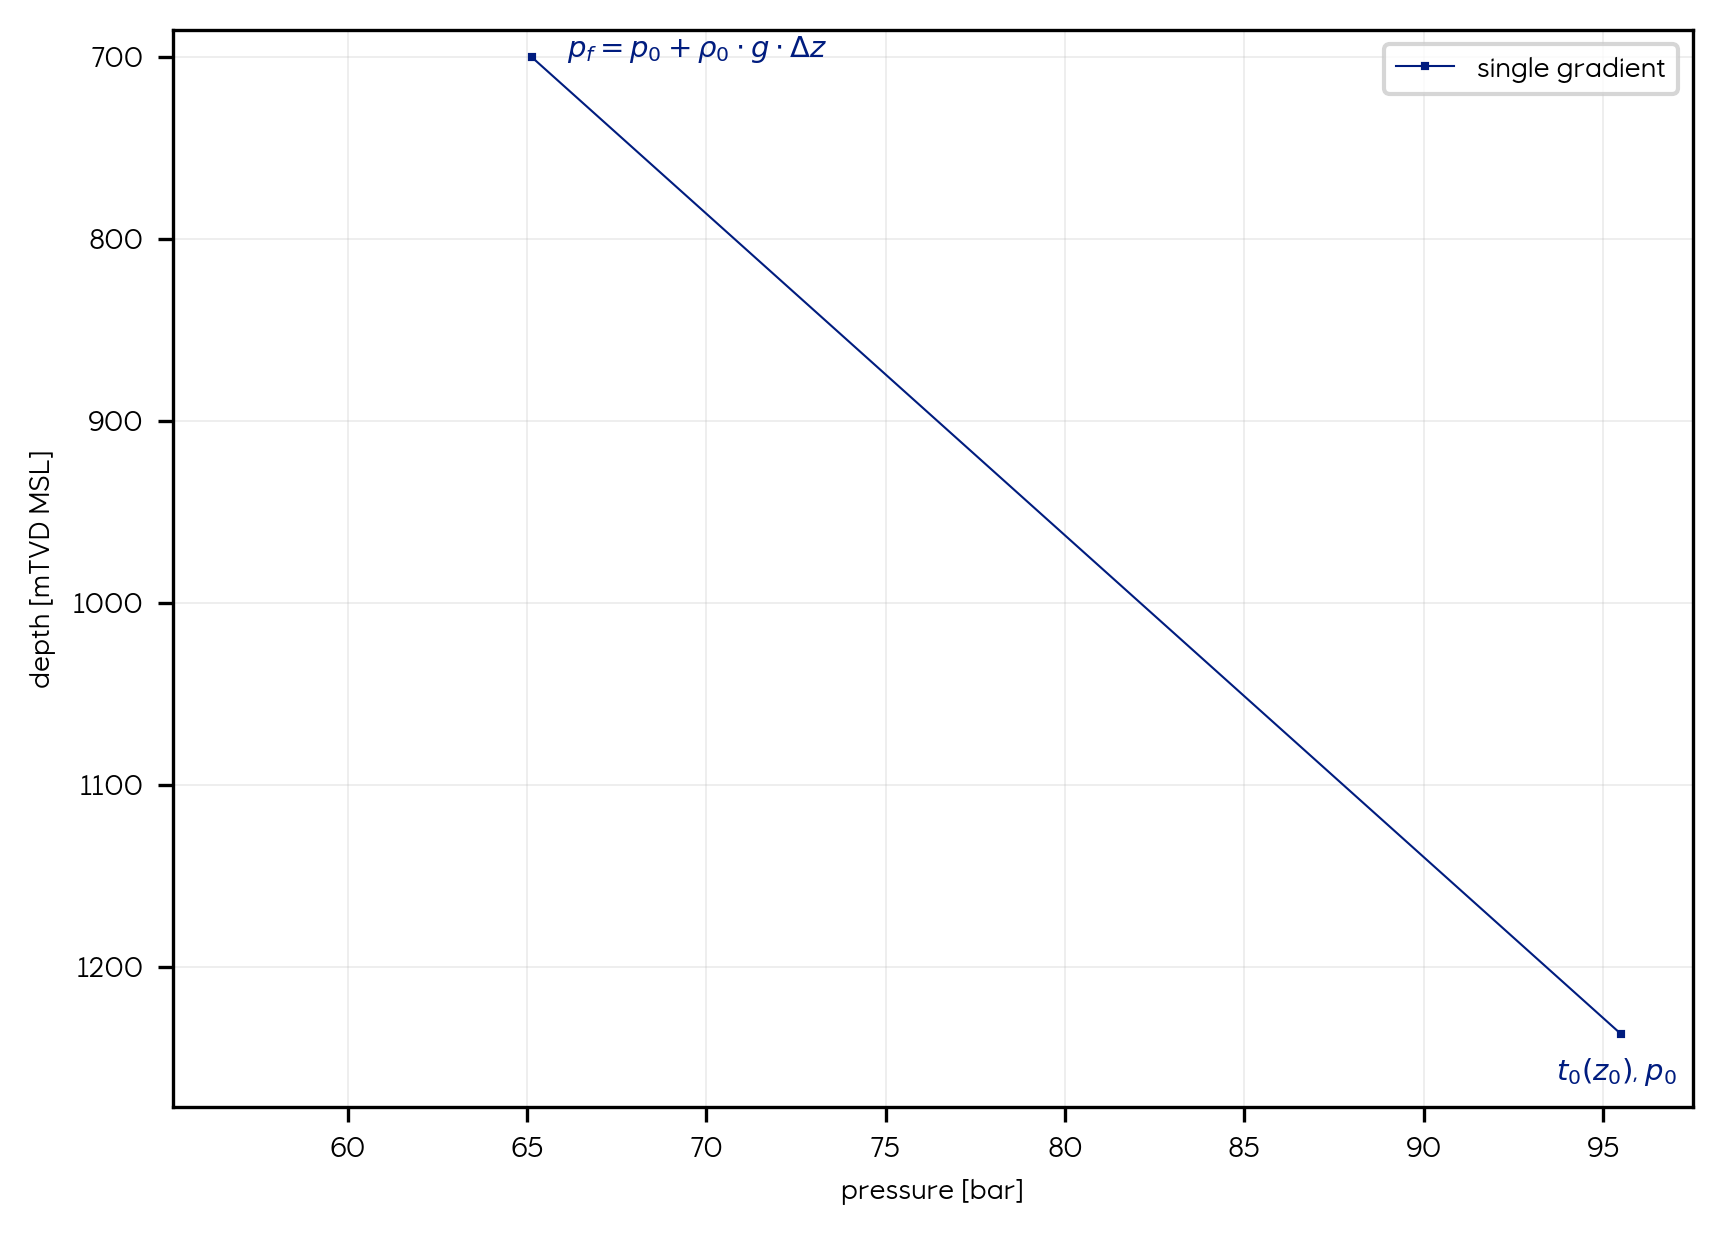

In [49]:
from WellClass.libs.pvt.pvt import get_rho_from_pvt_data
from scipy.interpolate import RectBivariateSpline

rcParams['lines.markersize'] = 2


pvt_data = load_pvt_data(pvt_path, 'pure_co2', load_fluid=True)
temperature_vector = pvt_data["temperature"]
pressure_vector = pvt_data["pressure"]
rho_matrix = pvt_data['pure_co2']["rho"]

fluid_interpolator = RectBivariateSpline(pressure_vector, temperature_vector, rho_matrix)

z0 = sf_depth_msl + scenario_definition_df['depth'].iloc[2]
p0 = scenario_definition_df['pressure'].iloc[2]

zf = 700

t0 = sf_temp_degc + scenario_definition_df['geothermal_gradient'].iloc[2] * (z0 - sf_depth_msl)  # degC

rho0 = get_rho_from_pvt_data(p0, t0, fluid_interpolator)


dpf = rho0 * const.g * (zf - z0) / const.bar
pf = p0 + dpf

# 3 step integration
steps = 4

dz = (zf - z0) / steps

z = np.zeros(steps + 1)
p = np.zeros(steps + 1)
t = np.zeros(steps + 1)

z[0] = z0
p[0] = p0
t[0] = t0

z[-1] = zf


for i in range(1, steps + 1):
    z[i] = z[i - 1] + dz
    t[i] = sf_temp_degc + scenario_definition_df['geothermal_gradient'].iloc[2] * (z[i] - sf_depth_msl)
    rho_i = get_rho_from_pvt_data(p[i - 1], t[i-1], fluid_interpolator)
    dp = rho_i * const.g * dz / const.bar
    p[i] = p[i - 1] + dp



# modelled tables
modelled_pressure = modelled_tables[scenario_definition_df['sc_name'].iloc[2]]['fluid_pressure']
modelled_depth = modelled_tables[scenario_definition_df['sc_name'].iloc[2]]['depth']

# olga curves
table = all_tables[scenario_definition_df['sc_name'].iloc[2]]
olga_pressure = table['pressure'].values
olga_depth = 312 + table['depth'].values


width_cm = 15
height_cm = 8

width_cm = 19.5*.75
height_cm = 13.98*.75


width_inch = width_cm / 2.54
height_inch = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width_inch, height_inch))

line1 = ax.plot([p0, pf], [z0, zf], marker = 's', label='single gradient', markersize=1) 
# line2 = ax.plot(p, z, marker='o', markersize=1, label = 'discrete integration (4 steps)')
# line3 = ax.plot(modelled_pressure, modelled_depth, label = 'full integration')

color = line1[0].get_color()
# color2 = line2[0].get_color()
# color3 = line3[0].get_color()
ax.annotate('$t_0(z_0)$, $p_0$  ', xy=(p0 , z0+25 ), color=color, ha='center', fontsize=7)
ax.annotate('$p_f=p_0 + \\rho_{0}\\cdot g \\cdot \\Delta z$  ', xy=(pf+1 , zf ), color=color, ha='left', fontsize=7)

# ax.plot(olga_pressure, olga_depth, label='OLGA pressure', color='red')
ax.legend()
ax.set_xlabel('pressure [bar]')
ax.set_ylabel('depth [mTVD MSL]')
ax.set_ylim(bottom=z0+40, top=zf-15)
ax.set_xlim(right=p0+2, left=pf-10)

fig.tight_layout()
fig.savefig(r'./co2_pressure_integration_comparison.svg', dpi=300)

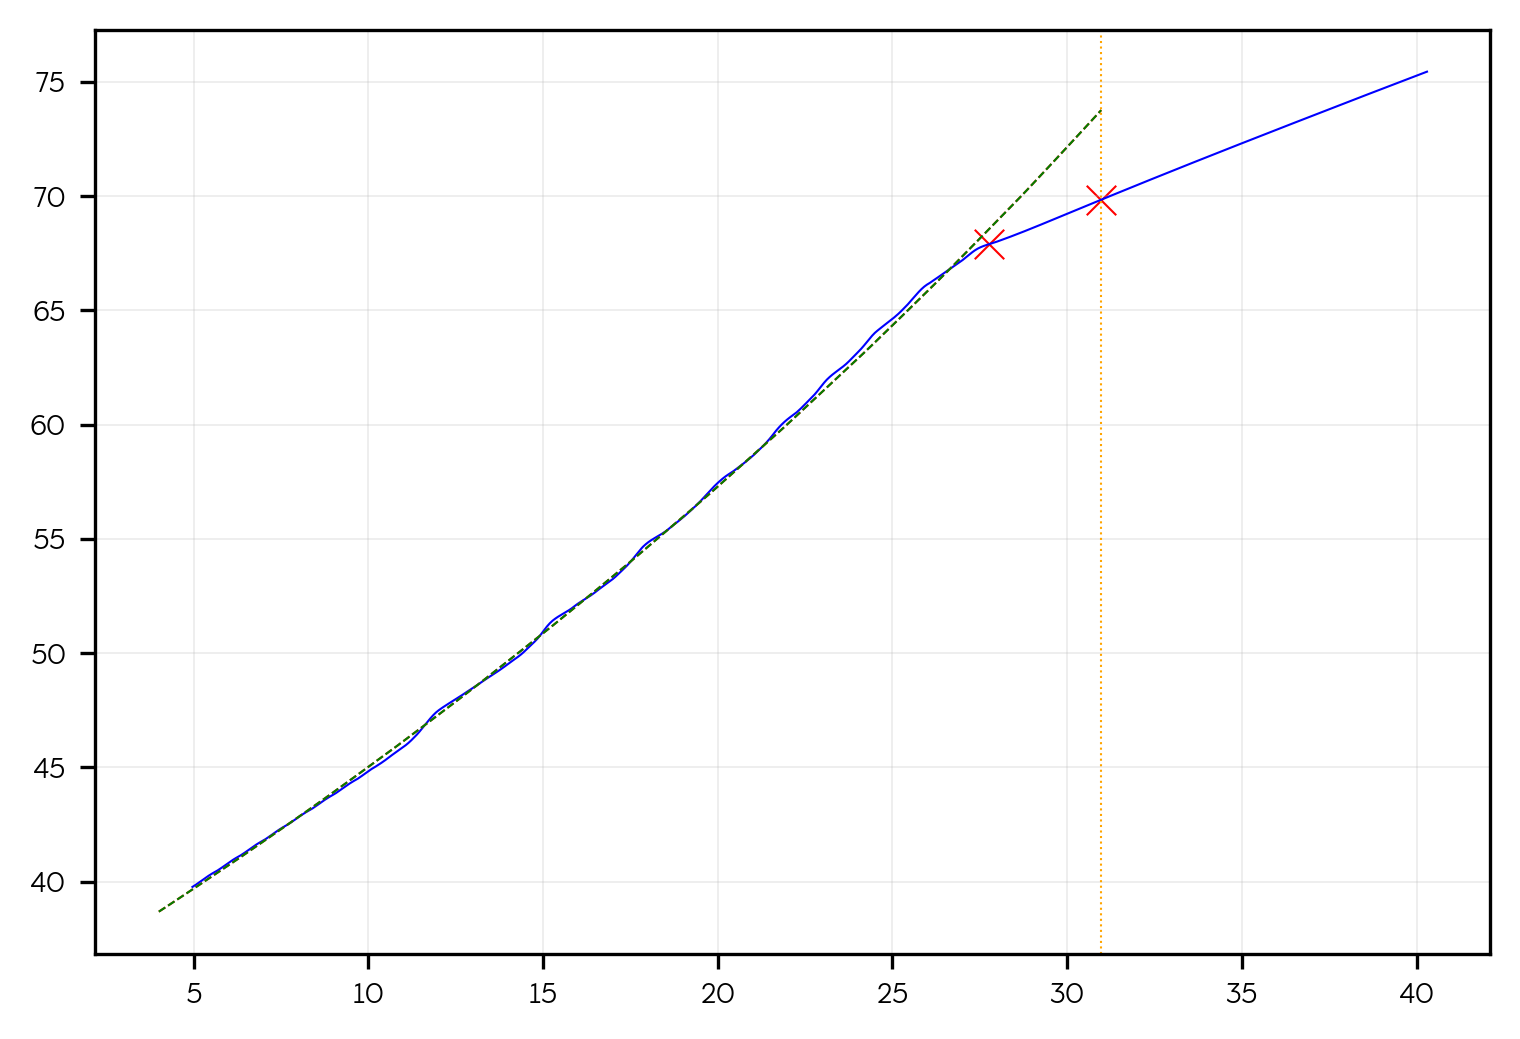

In [50]:
case = "pure_co2_75bar"

fluid = "_".join(case.split("_")[:-1])
pressure = modelled_tables[case]["fluid_pressure"].to_numpy()

temps = modelled_tables[case]["temperature"].to_numpy()


dew_interp = all_pvt_data[fluid][fluid]["dew_point"]
bub_interp = all_pvt_data[fluid][fluid]["bubble_point"]
T_crit = all_pvt_data[fluid][fluid]["metadata"]["T_crit"]


if dew_interp is not None:
    try:
        p_dew_vals = np.asarray(dew_interp(temps), dtype=float)
        # ensure shape matches temps
        if p_dew_vals.shape != temps.shape:
            p_dew_vals = np.broadcast_to(p_dew_vals, temps.shape).copy()
    except Exception:
        p_dew_vals = np.full(temps.shape, np.nan, dtype=float)
else:
    p_dew_vals = np.full(temps.shape, np.nan, dtype=float)


if bub_interp is not None:
    try:
        p_bub_vals = np.asarray(bub_interp(temps), dtype=float)
        if p_bub_vals.shape != temps.shape:
            p_bub_vals = np.broadcast_to(p_bub_vals, temps.shape).copy()
    except Exception:
        p_bub_vals = np.full(temps.shape, np.nan, dtype=float)
else:
    p_bub_vals = np.full(temps.shape, np.nan, dtype=float)

p_bub_vals

bubble_point = np.loadtxt(pvt_path / fluid / "bubble_point.csv", delimiter=",", skiprows=1)
dew_point = np.loadtxt(pvt_path / fluid / "dew_point.csv", delimiter=",", skiprows=1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(temps, pressure, label="Modelled Pressure-Temperature", color="blue")
ax.plot(temps, p_dew_vals, label="Dew Point", color="red", linestyle="--")
ax.plot(temps, p_bub_vals, label="Bubble Point", color="green", linestyle="--")
ax.axvline(x=T_crit, color="orange", linestyle=":", label="Critical Temperature")

# ax.scatter(bubble_point[:, 0], bubble_point[:, 1], color="green", marker="o", s=5, label="Bubble Point Data")
# ax.scatter(dew_point[:, 0], dew_point[:, 1], color="red", marker="o", s=5, label="Dew Point Data")

for warning in warnings[case]:
    ax.scatter(
        warning["T"],
        warning["p"],
        color="red",
        marker="x",
        s=50,
        label="Warning Point" if "Warning Point" not in ax.get_legend_handles_labels()[1] else "",
    )

In [51]:
pvt_pure_co2 = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type="pure_co2")


T_crit = pvt_pure_co2["pure_co2"]["metadata"]["T_crit"]
pvt_pure_co2["pure_co2"]["dew_point"]

pure_co2_bp_int = pvt_pure_co2["pure_co2"]["dew_point"]


In [52]:
case = "pure_co2_95bar"


query = modelled_tables["pure_co2_95bar"].query("~fluid_pressure.isna() & temperature >= @T_crit ")

modelled_tables["pure_co2_95bar"]["phase"] = ""
modelled_tables["pure_co2_95bar"]["dew point"] = np.nan


modelled_tables["pure_co2_95bar"].loc[query.index, "phase"] = "supercritical"

query = modelled_tables["pure_co2_95bar"].query("~fluid_pressure.isna() & temperature < @T_crit ")


modelled_tables["pure_co2_95bar"].loc[query.index, "dew point"] = pure_co2_bp_int(query["temperature"].values)

modelled_tables["pure_co2_95bar"].query("~fluid_pressure.isna()")


,depth,temperature,hydrostatic_pressure,min_horizontal_stress,fluid_pressure,brine_pressure,phase,dew point
337.0000,337.0000,4.981623,34.943053,39.924695,39.806565,5.132252,,39.680848
338.0000,338.0000,5.020888,35.043788,40.224695,39.845724,5.232852,,39.720904
339.0000,339.0000,5.060153,35.144524,40.524695,39.885764,5.333452,,39.760980
340.0000,340.0000,5.099418,35.245260,40.824695,39.926887,5.434052,,39.801075
341.0000,341.0000,5.138683,35.345996,41.124695,39.969300,5.534652,,39.841187
...,...,...,...,...,...,...,...,...
1233.0000,1233.0000,40.163007,125.047671,308.724695,95.279427,95.113957,supercritical,NaN
1234.0000,1234.0000,40.202272,125.147859,309.024695,95.336148,95.214017,supercritical,NaN
1235.0000,1235.0000,40.241537,125.248045,309.324695,95.392823,95.314076,supercritical,NaN
1236.0000,1236.0000,40.280802,125.348230,309.624695,95.449452,95.414134,supercritical,NaN


In [53]:
pure_co2_bp_int(1000)

array(nan)

In [54]:
warnings["pure_co2_95bar"]

[{'p': np.float64(80.74739278594687),
  'T': np.float64(30.97501188100817),
  'z': np.float64(999.0),
  'message': 'Message: Fluid changed phase from supercritical to liquid at 999.0 mTVDMSL (P = 80.7 bar).'},
 {'p': np.float64(53.23660522526386),
  'T': np.float64(16.36845522928322),
  'z': np.float64(627.0),
  'message': '\n                        Warning: At depth 627.0 m, the phase change to liquid. Pressures above this depth \n                        cannot be accurately resolved by this method. For reliable pressure profiles above 627.0 m,\n                        use OLGA Dynamic Multiphase Flow Simulator (SLB).\n                      '}]

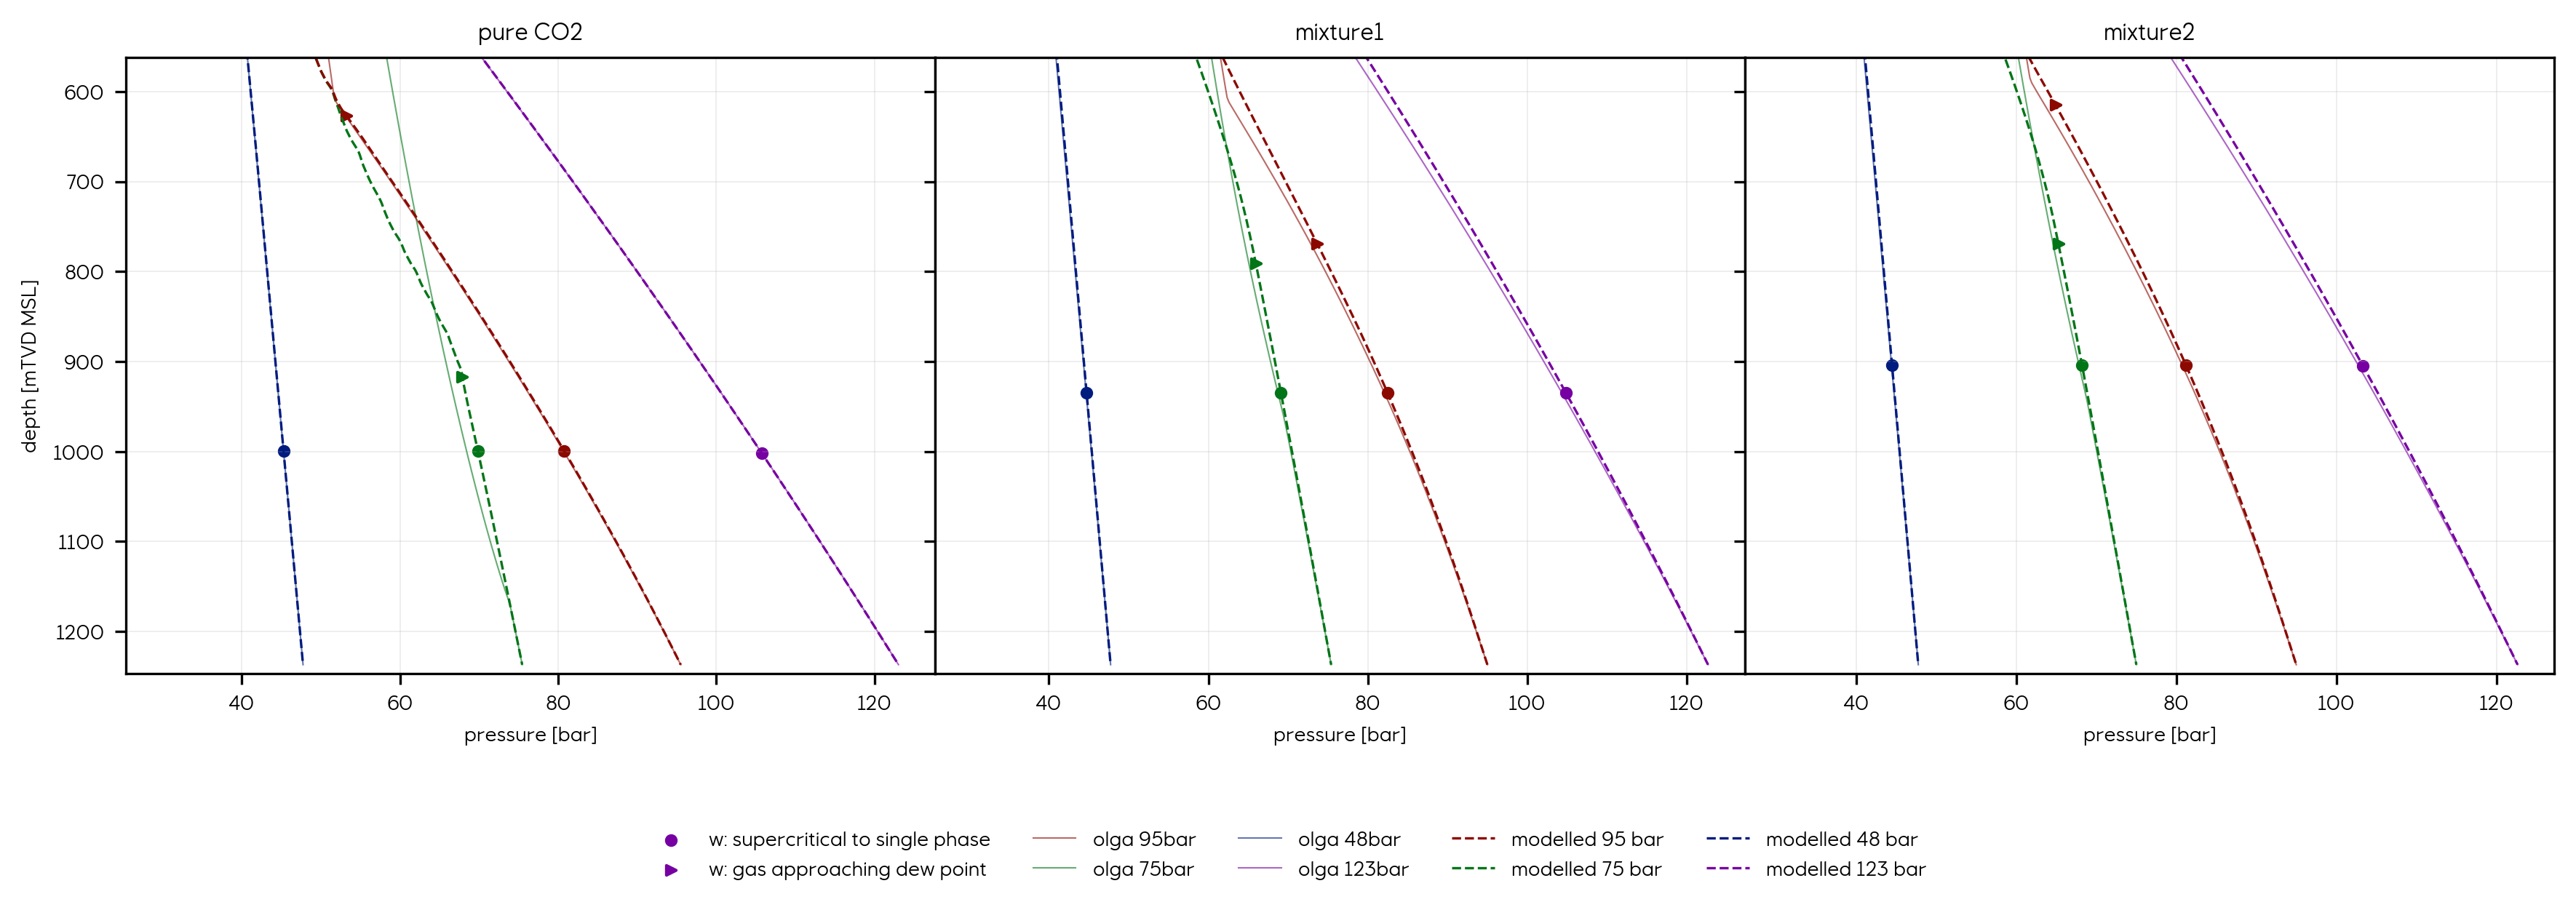

In [55]:
width_cm = 17
height_cm = 9

width_cm = 30
height_cm = 10.48


width_inch = width_cm / 2.54
height_inch = height_cm / 2.54

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(width_inch, height_inch))

for idx, row in scenario_definition_df.iterrows():
    sc_name = row["sc_name"]
    table = all_tables[sc_name]

    olga_pressure = table["pressure"].values
    olga_depth = 312 + table["depth"].values

    # olga_pressure = olga_pressure[olga_depth >= 244+312]
    # olga_depth = olga_depth[olga_depth >= 244 +312]

    modelled_pressure = modelled_tables[row["sc_name"]]["fluid_pressure"]
    modelled_depth = modelled_tables[row["sc_name"]]["depth"]

    olga_line = ax[idx // 4].plot(olga_pressure, olga_depth, label=f"olga {row['pressure']:.0f}bar", alpha=0.6)
    color = olga_line[0].get_color()
    ax[idx // 4].plot(
        modelled_tables[row["sc_name"]]["fluid_pressure"],
        modelled_tables[row["sc_name"]]["depth"],
        label=f"modelled {row['pressure']:.0f} bar",
        ls="--",
        color=color,
        lw=0.8,
    )

    for warning in warnings[sc_name]:
        p = warning["p"]
        z = warning["z"]
        msg = warning["message"]

        if "message" in msg.lower():
            markerstyle = "o"
            label = "w: supercritical to single phase"
        elif "bubble" in msg.lower():
            markerstyle = "<"
            label = "w: liquid approaching bubble point"
        else:
            markerstyle = ">"
            label = "w: gas approaching dew point"

        ax[idx // 4].scatter(p, z, color=color, marker=markerstyle, s=10, label=label)

    if ax[idx // 4].get_title() == "":
        mixture_name = row["fluid_name"]
        ax[idx // 4].set_title(mixture_name, wrap=True)


ax[0].set_ylim(bottom=312 + 250, top=olga_depth.max() + 10)


for i in range(3):
    ax[i].set_xlabel("pressure [bar]")
ax[0].set_ylabel("depth [mTVD MSL]")

ax[0].invert_yaxis()


handles, labels = [], []
for a in ax:
    h, l = a.get_legend_handles_labels()
    
    handles.extend(h)
    labels.extend(l)



order = sorted(range(len(labels)), key=lambda i: str.lower(labels[i]), reverse=True)
handles_sorted = [handles[i] for i in order]
labels_sorted  = [labels[i]  for i in order]


# Remove duplicate labels
unique = dict(zip(labels_sorted, handles_sorted))
fig.legend(
    unique.values(),
    unique.keys(),
    loc="lower center",
    bbox_to_anchor=(0.5, 0),
    ncol=5,
    frameon=False,
)

fig.tight_layout()
fig.subplots_adjust(wspace=0, bottom=0.25)


fig.savefig(r"./co2_pressure_comparison.png", bbox_inches="tight")


/tmp/ipykernel_38067/2292852045.py:71: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


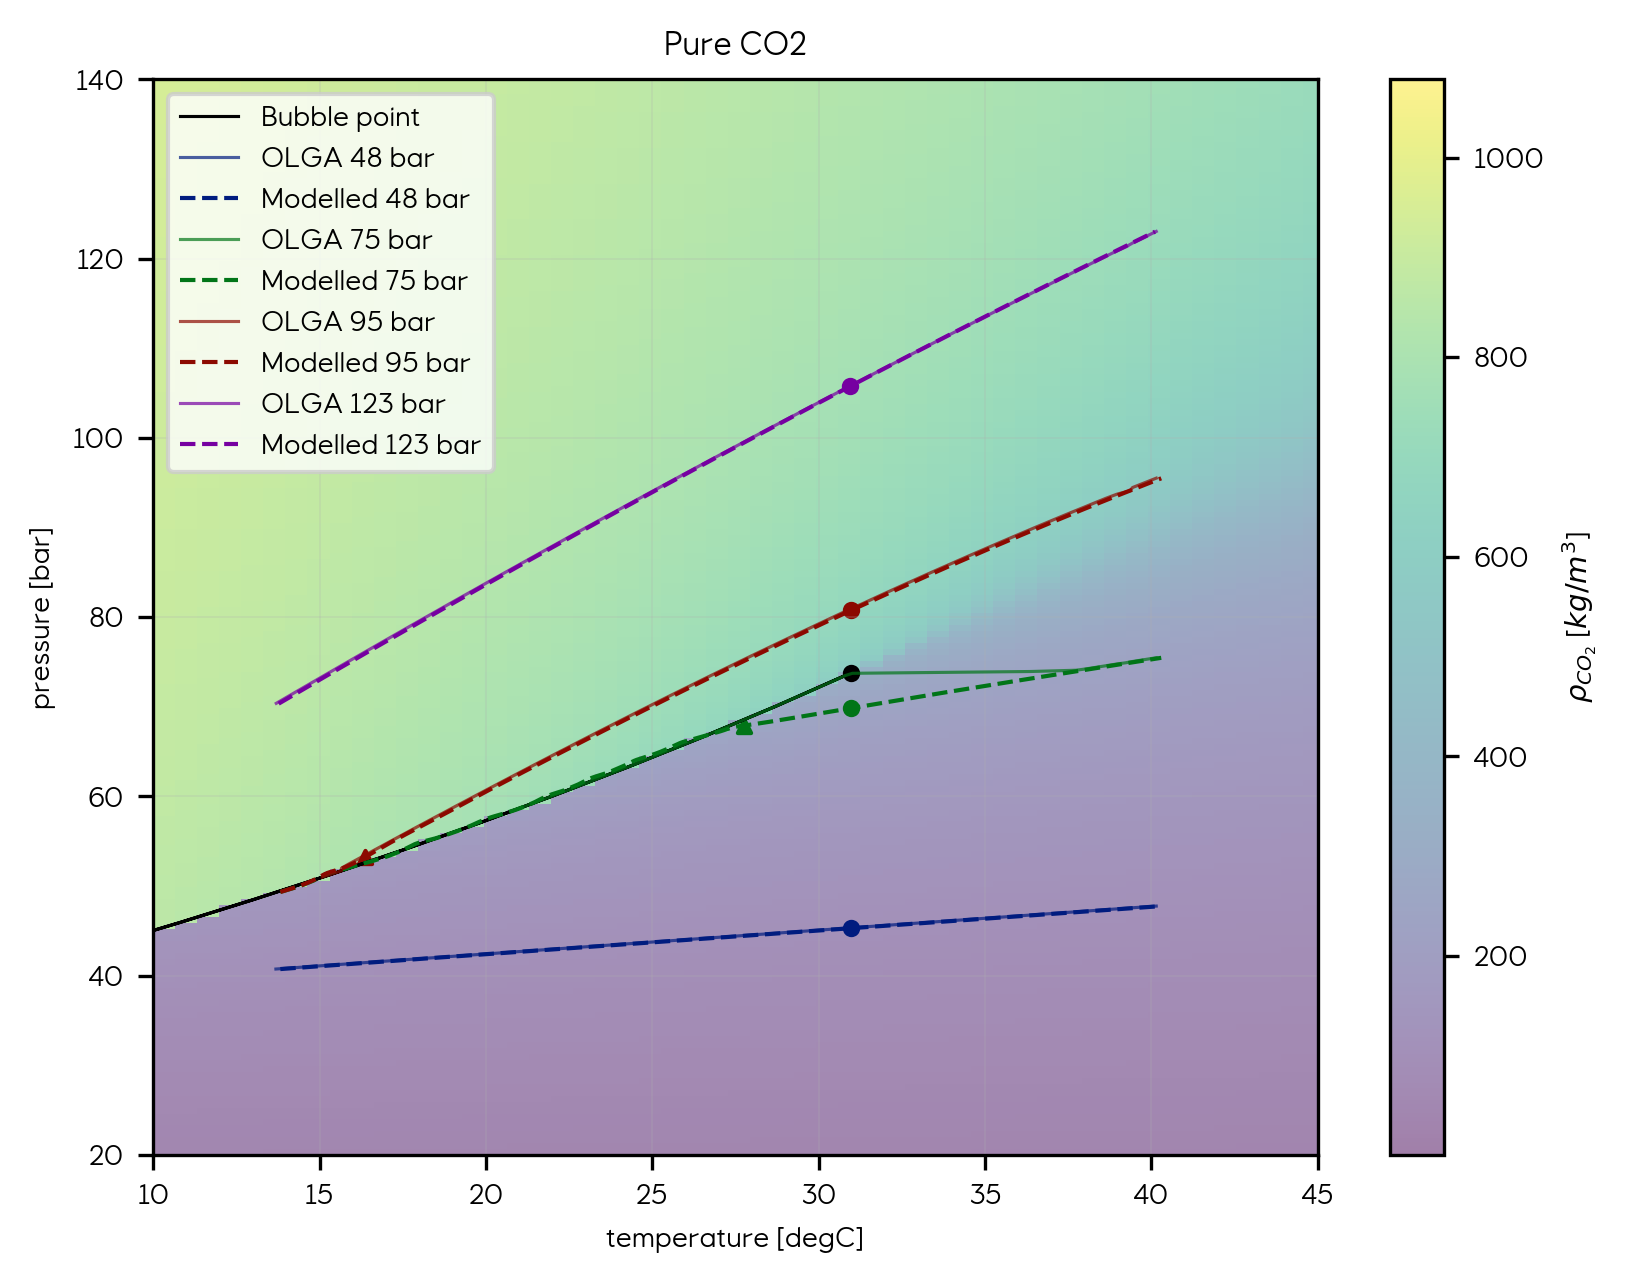

In [56]:
# Plot tables
from itertools import cycle

height = 10.89 / (const.inch * 100)
width = 14 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_co2 = ax.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["pure_co2"]["rho"], alpha=0.5)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")


ax.plot(co2_envelopes["bubble_point"][:, 0], co2_envelopes["bubble_point"][:, 1], color="black", lw=0.75, label="Bubble point")
ax.scatter([co2_mixture_info["T_crit"]], [co2_mixture_info["p_crit"]], color="black", s=10)

for idx, row in scenario_definition_df.query("fluid_id == 'pure_co2'").iterrows():
    scenario = row["sc_name"]
    modelled_table = modelled_tables[scenario].query("depth>=250+312")
    olga_table = all_tables[scenario].query("depth>=250")

    olga_line = ax.plot(olga_table["temperature"], olga_table["pressure"], label=f"OLGA {row['pressure']:.0f} bar", lw=0.75, alpha=0.7, markersize=1)
    color = olga_line[0].get_color()
    ax.plot(
        modelled_table["temperature"],
        modelled_table["fluid_pressure"],
        label=f"Modelled {row['pressure']:.0f} bar",
        lw=1,
        color=color,
        ls="--",
    )

    for warning in warnings[scenario]:
        p = warning["p"]
        z = warning["z"]
        Temp = warning["T"]
        msg = warning["message"]

        if "message" in msg.lower():
            markerstyle = "o"
            label = "w: supercritical to single phase"
        elif "bubble" in msg.lower():
            markerstyle = "v"
            label = "w: liquid approaching bubble point"
        else:
            markerstyle = "^"
            label = "w: gas approaching dew point"

        ax.scatter(Temp, p, color=color, marker=markerstyle, s=10)



# for scenario, color in zip(p_models, color_cycle):
#     p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
#         "temperature", "fluid_pressure", ax=ax, label=f"PVT {scenario} bar", lw=1
#     )

#     ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

# ax.plot(pure_co2_T, pure_co2_P)

ax.set_xlim(10, 45)

ax.set_ylim(20, 140)
ax.legend()

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")
ax.set_title("Pure CO2")

fig.tight_layout()

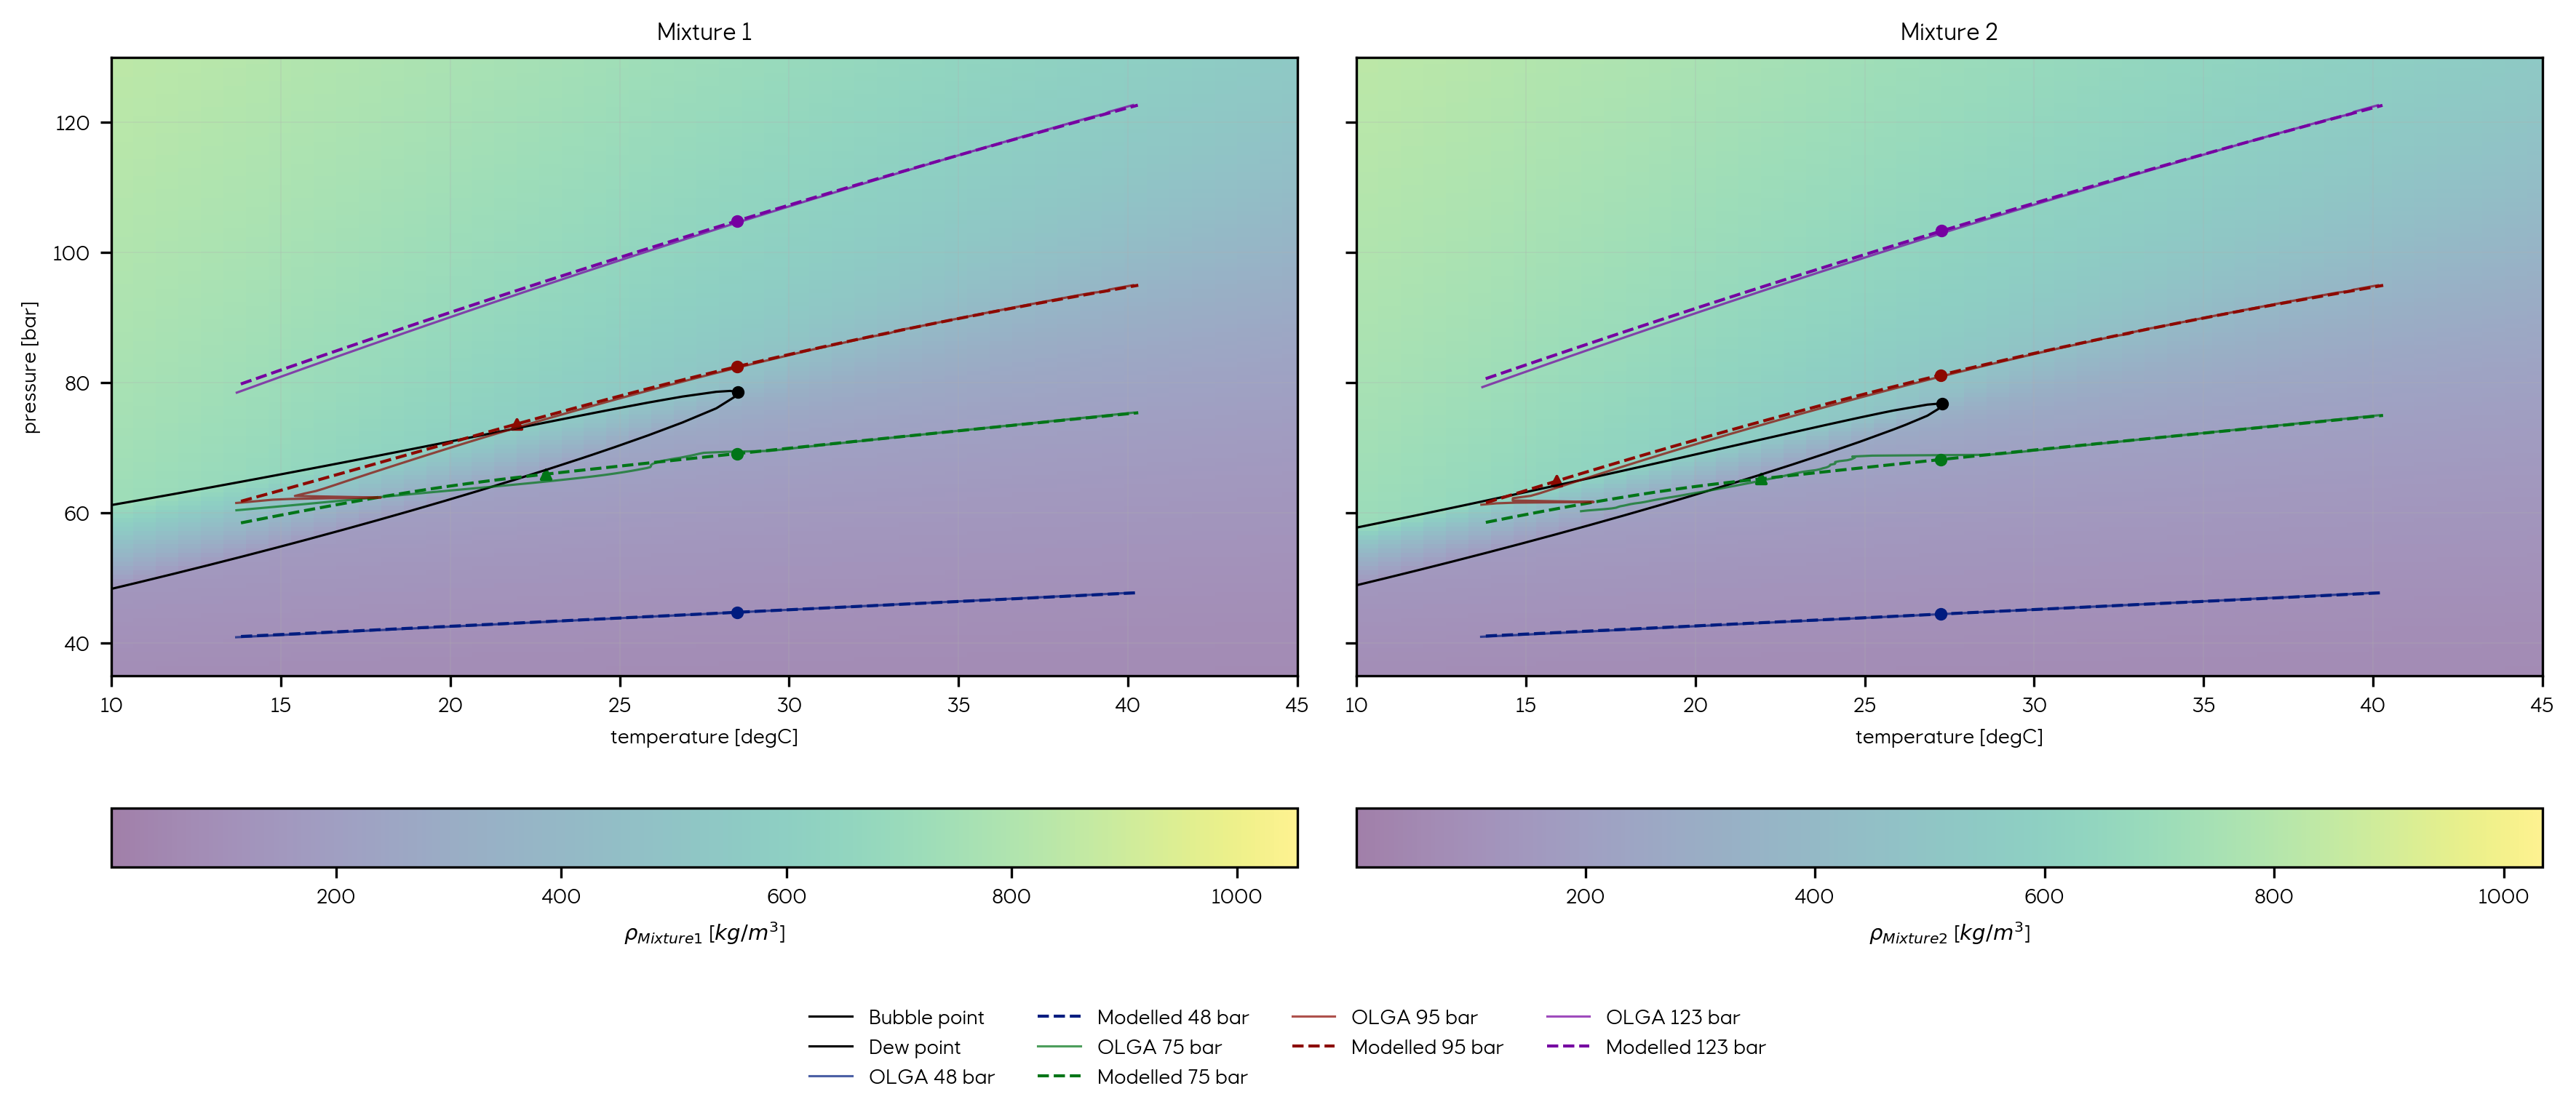

In [57]:
# Plot tables
from itertools import cycle

height = 12.9 / (const.inch * 100)
width = 30 / (const.inch * 100)




fig, (ax, ax2) = plt.subplots(1, 2, figsize=(width, height), sharex=True, sharey=True)
# Plot density colormap
rho_pcm_mix1 = ax.pcolormesh(mix1_pvt_data["temperature"], mix1_pvt_data["pressure"], mix1_pvt_data["mixture1"]["rho"], alpha=0.5)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")


ax.plot(mix1_envelopes["bubble_point"][:, 0], mix1_envelopes["bubble_point"][:, 1], color="black", lw=0.75, label="Bubble point")
ax.plot(mix1_envelopes["dew_point"][:, 0], mix1_envelopes["dew_point"][:, 1], color="black", lw=0.75, label="Dew point")
ax.scatter([mix1_mixture_info["T_crit"]], [mix1_mixture_info["p_crit"]], color="black", s=10)

for idx, row in scenario_definition_df.query("fluid_id == 'mixture1'").iterrows():
    scenario = row["sc_name"]
    modelled_table = modelled_tables[scenario].query("depth>=250+312")
    olga_table = all_tables[scenario].query("depth>=250")

    olga_line = ax.plot(
        olga_table["temperature"], olga_table["pressure"], label=f"OLGA {row['pressure']:.0f} bar", lw=0.75, alpha=0.7, 
    )
    color = olga_line[0].get_color()
    ax.plot(modelled_table["temperature"], modelled_table["fluid_pressure"], label=f"Modelled {row['pressure']:.0f} bar", lw=1, color=color, ls="--")

    for warning in warnings[scenario]:
        p = warning["p"]
        z = warning["z"]
        Temp = warning["T"]
        msg = warning["message"]

        if "message" in msg.lower():
            markerstyle = "o"
            label = "w: supercritical to single phase"
        elif "bubble" in msg.lower():
            markerstyle = "v"
            label = "w: liquid approaching bubble point"
        else:
            markerstyle = "^"
            label = "w: gas approaching dew point"

        ax.scatter(Temp, p, color=color, marker=markerstyle, s=10)



ax.set_xlim(10, 45)

ax.set_ylim(20, 140)
# ax.legend()


rho_pcm_mix2 = ax2.pcolormesh(mix2_pvt_data["temperature"], mix2_pvt_data["pressure"], mix2_pvt_data["mixture2"]["rho"], alpha=0.5)

ax2.set_xlabel("temperature [degC]")
# ax2.set_ylabel("pressure [bar]")


ax2.plot(mix2_envelopes["bubble_point"][:, 0], mix2_envelopes["bubble_point"][:, 1], color="black", lw=0.75, label="Bubble point")
ax2.plot(mix2_envelopes["dew_point"][:, 0], mix2_envelopes["dew_point"][:, 1], color="black", lw=0.75, label="Dew point")
ax2.scatter([mix2_mixture_info["T_crit"]], [mix2_mixture_info["p_crit"]], color="black", s=10)

for idx, row in scenario_definition_df.query("fluid_id == 'mixture2'").iterrows():
    scenario = row["sc_name"]
    modelled_table = modelled_tables[scenario].query("depth>=250+312")
    olga_table = all_tables[scenario].query("depth>=250")

    olga_line = ax2.plot(
        olga_table["temperature"], olga_table["pressure"], label=f"OLGA {row['pressure']:.0f} bar", lw=0.75, alpha=0.7, 
    )
    color = olga_line[0].get_color()
    ax2.plot(modelled_table["temperature"], modelled_table["fluid_pressure"], label=f"Modelled {row['pressure']:.0f} bar", lw=1, color=color, ls="--")

    for warning in warnings[scenario]:
        p = warning["p"]
        z = warning["z"]
        Temp = warning["T"]
        msg = warning["message"]

        if "message" in msg.lower():
            markerstyle = "o"
            label = "w: supercritical to single phase"
        elif "bubble" in msg.lower():
            markerstyle = "v"
            label = "w: liquid approaching bubble point"
        else:
            markerstyle = "^"
            label = "w: gas approaching dew point"

        ax2.scatter(Temp, p, color=color, marker=markerstyle, s=10)



# ax.plot(t1, p1)
# ax2.plot(t2, p2)

ax2.set_xlim(10, 45)

ax2.set_ylim(35, 130)
# ax.legend()


fig.colorbar(rho_pcm_mix1, label=r"$\rho_{Mixture 1}$ [$kg/m^3$]", orientation="horizontal", ax=ax)
ax.set_title("Mixture 1")


fig.colorbar(rho_pcm_mix2, label=r"$\rho_{Mixture 2}$ [$kg/m^3$]", orientation="horizontal", ax=ax2)
ax2.set_title("Mixture 2")


handles, labels = [], []
for a in [ax, ax2]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels
unique = dict(zip(labels, handles))
fig.legend(
    unique.values(),
    unique.keys(),
    loc="lower center",
    bbox_to_anchor=(0.5, 0),
    ncol=4,
    frameon=False,
)


fig.tight_layout()

fig.subplots_adjust(wspace=0.05, bottom=0.15)

fig.savefig(r"./co2_pressure_comparison.png", bbox_inches="tight")

/tmp/ipykernel_38067/2846412229.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


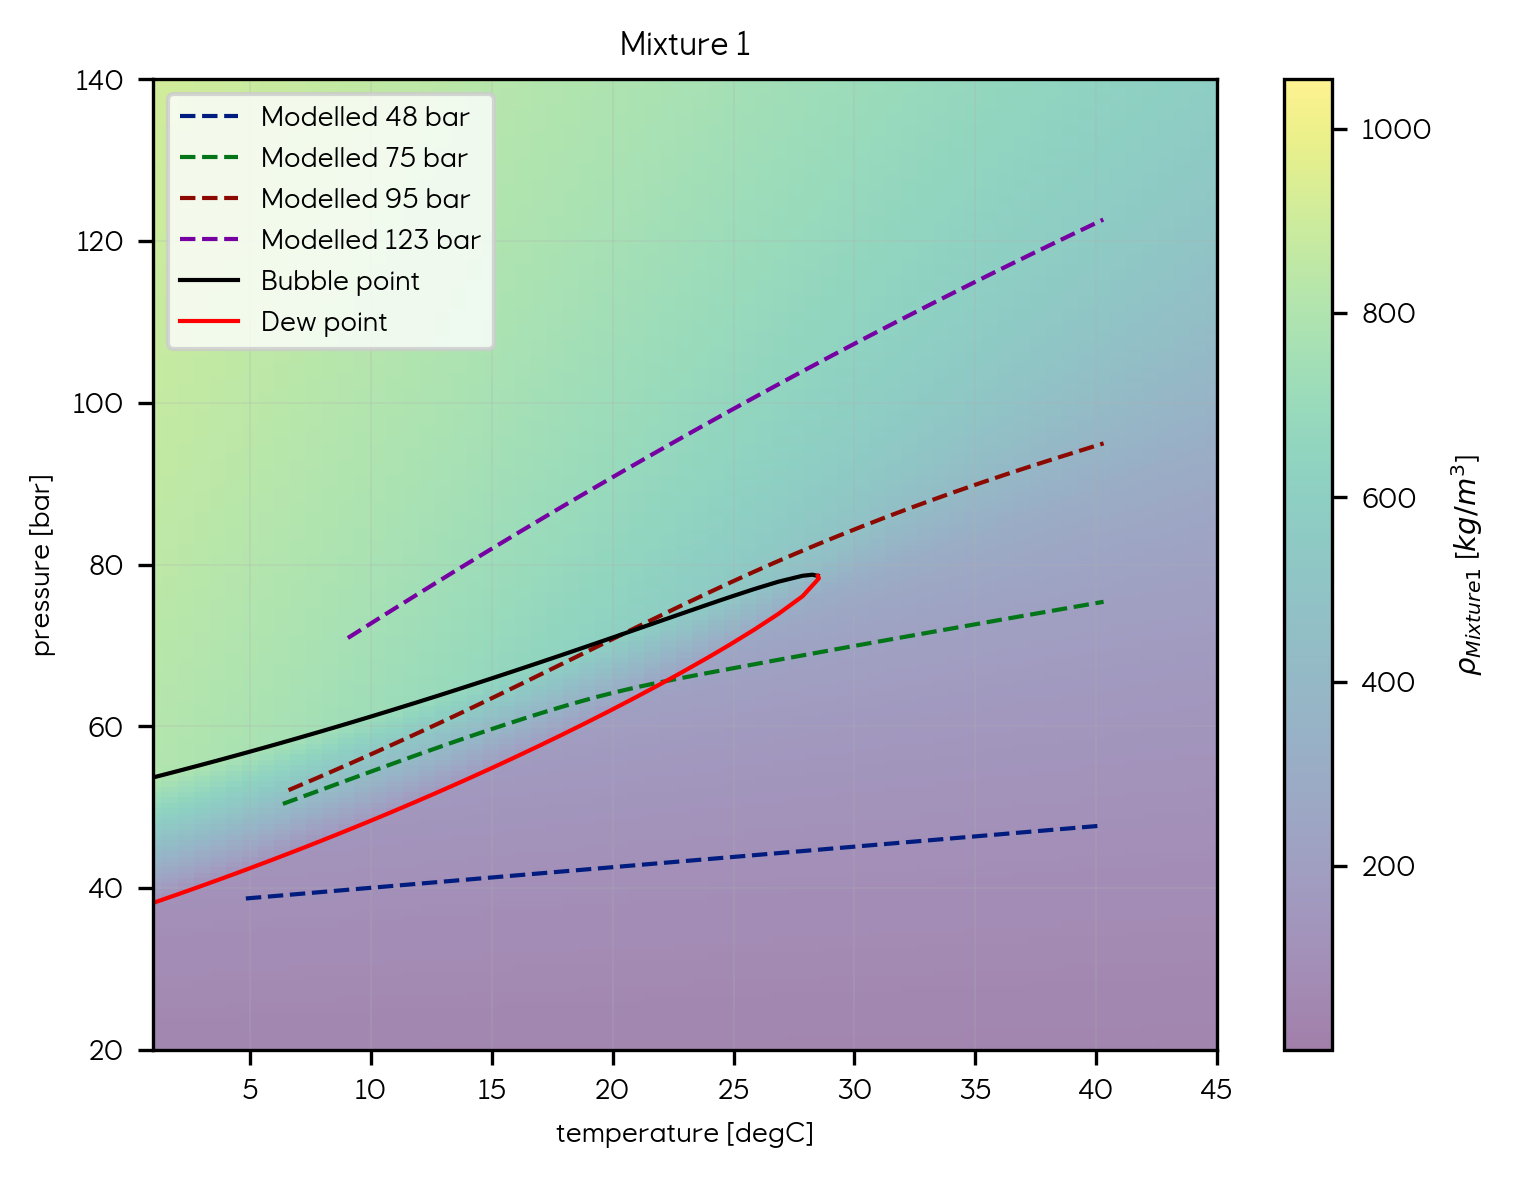

In [58]:
# Plot tables
from itertools import cycle

height = 10 / (const.inch * 100)
width = 13 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_mix1 = ax.pcolormesh(mix1_pvt_data["temperature"], mix1_pvt_data["pressure"], mix1_pvt_data["mixture1"]["rho"], alpha=0.5)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")


for idx, row in scenario_definition_df.query("fluid_id == 'mixture1'").iterrows():
    scenario = row["sc_name"]
    modelled_table = modelled_tables[scenario]
    # olga_table = all_tables[scenario].query('depth>=250')

    # olga_line = ax.plot(olga_table['temperature'], olga_table['pressure'], label=f'OLGA {row["pressure"]:.0f} bar', lw=0.75, alpha=0.7)
    # color = olga_line[0].get_color()
    ax.plot(modelled_table["temperature"], modelled_table["fluid_pressure"], label=f"Modelled {row['pressure']:.0f} bar", lw=1, ls="--")
    # if warnings[scenario] is not None:
    #     ax.axhline(warnings[scenario]["p_value"], color="red")


ax.plot(mix1_envelopes["bubble_point"][:, 0], mix1_envelopes["bubble_point"][:, 1], color="black", lw=1, label="Bubble point")
ax.plot(mix1_envelopes["dew_point"][:, 0], mix1_envelopes["dew_point"][:, 1], color="red", lw=1, label="Dew point")

# for scenario, color in zip(p_models, color_cycle):
#     p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
#         "temperature", "fluid_pressure", ax=ax, label=f"PVT {scenario} bar", lw=1
#     )

#     ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

# ax.plot(mix2_T, mix2_P)

ax.set_xlim(1, 45)

ax.set_ylim(20, 140)
ax.legend()

fig.colorbar(rho_pcm_mix1, label=r"$\rho_{Mixture 1}$ [$kg/m^3$]")
ax.set_title("Mixture 1")

fig.tight_layout()

/tmp/ipykernel_38067/2336029228.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


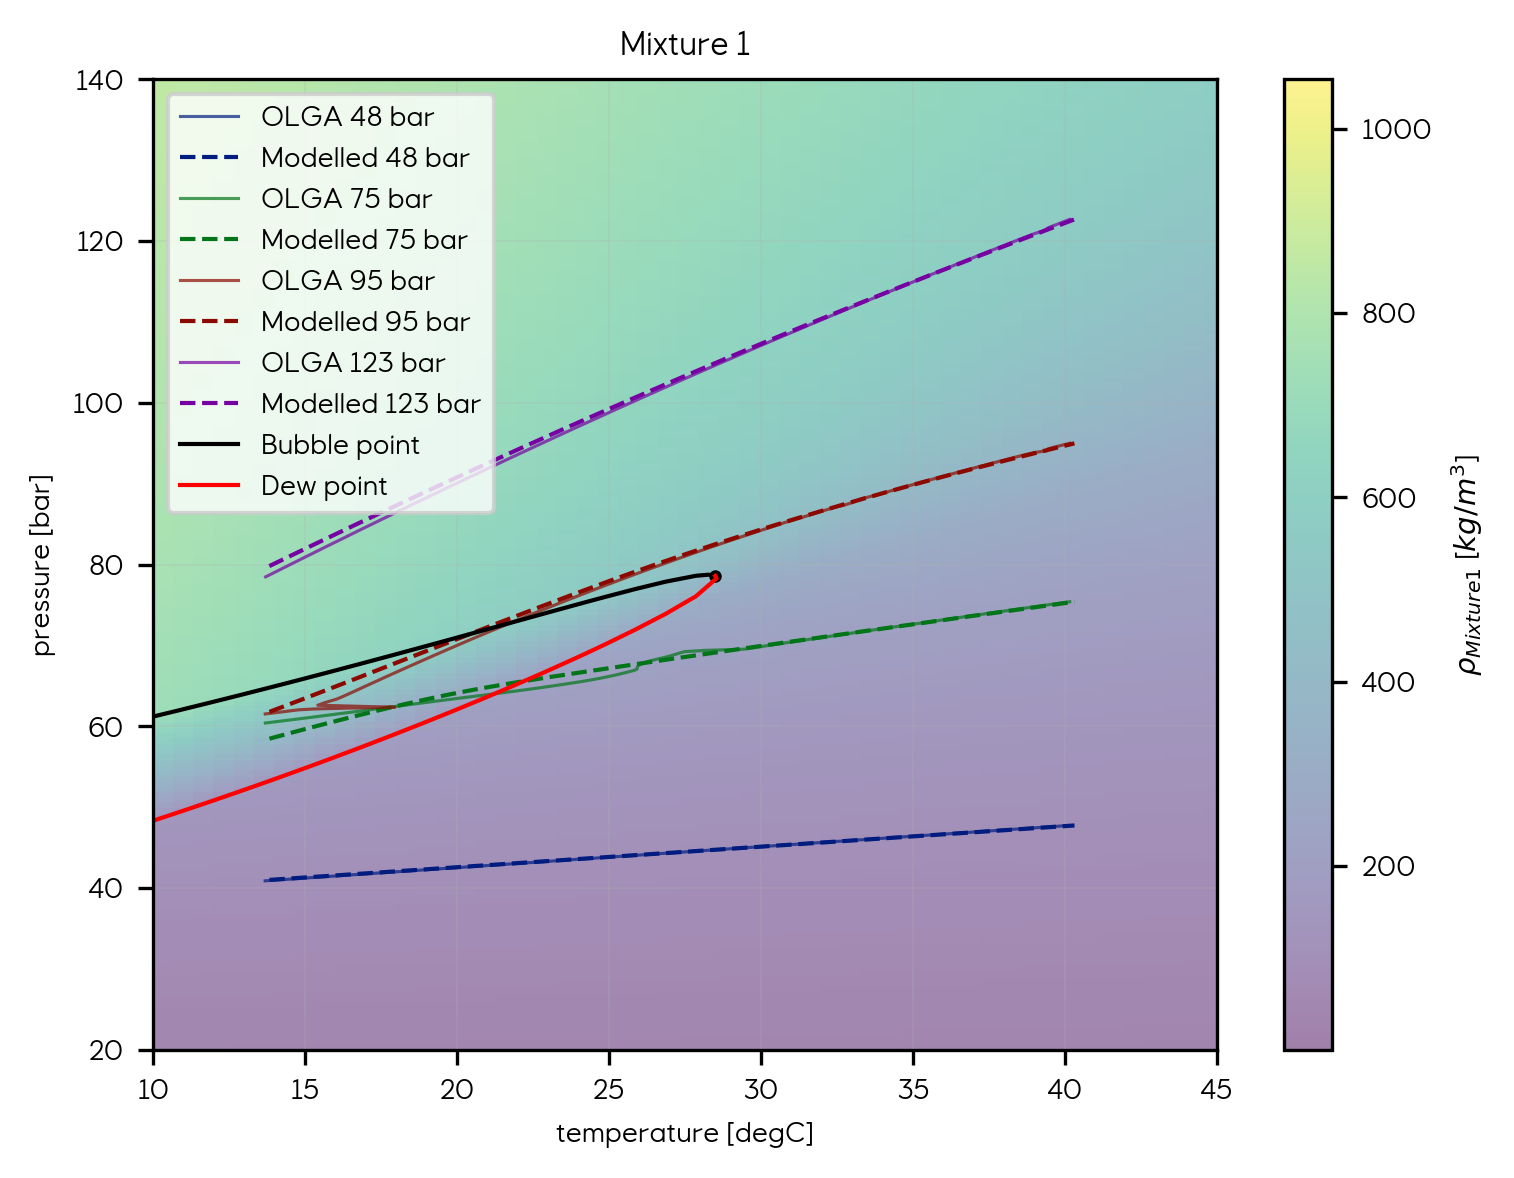

In [59]:
# Plot tables
from itertools import cycle

height = 10 / (const.inch * 100)
width = 13 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_mix1 = ax.pcolormesh(mix1_pvt_data["temperature"], mix1_pvt_data["pressure"], mix1_pvt_data["mixture1"]["rho"], alpha=0.5)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")


for idx, row in scenario_definition_df.query("fluid_id == 'mixture1'").iterrows():
    scenario = row["sc_name"]
    modelled_table = modelled_tables[scenario].query("depth>=250+312")
    olga_table = all_tables[scenario].query("depth>=250")

    olga_line = ax.plot(olga_table["temperature"], olga_table["pressure"], label=f"OLGA {row['pressure']:.0f} bar", lw=0.75, alpha=0.7)
    color = olga_line[0].get_color()
    ax.plot(modelled_table["temperature"], modelled_table["fluid_pressure"], label=f"Modelled {row['pressure']:.0f} bar", lw=1, color=color, ls="--")


ax.plot(mix1_envelopes["bubble_point"][:, 0], mix1_envelopes["bubble_point"][:, 1], color="black", lw=1, label="Bubble point")
ax.plot(mix1_envelopes["dew_point"][:, 0], mix1_envelopes["dew_point"][:, 1], color="red", lw=1, label="Dew point")
ax.scatter([mix1_mixture_info["T_crit"]], [mix1_mixture_info["p_crit"]], color="black")

# for scenario, color in zip(p_models, color_cycle):
#     p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
#         "temperature", "fluid_pressure", ax=ax, label=f"PVT {scenario} bar", lw=1
#     )

#     ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

# ax.plot(mix2_T, mix2_P)

ax.set_xlim(10, 45)

ax.set_ylim(20, 140)
ax.legend()

fig.colorbar(rho_pcm_mix1, label=r"$\rho_{Mixture 1}$ [$kg/m^3$]")
ax.set_title("Mixture 1")

fig.tight_layout()

/tmp/ipykernel_38067/4115637073.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


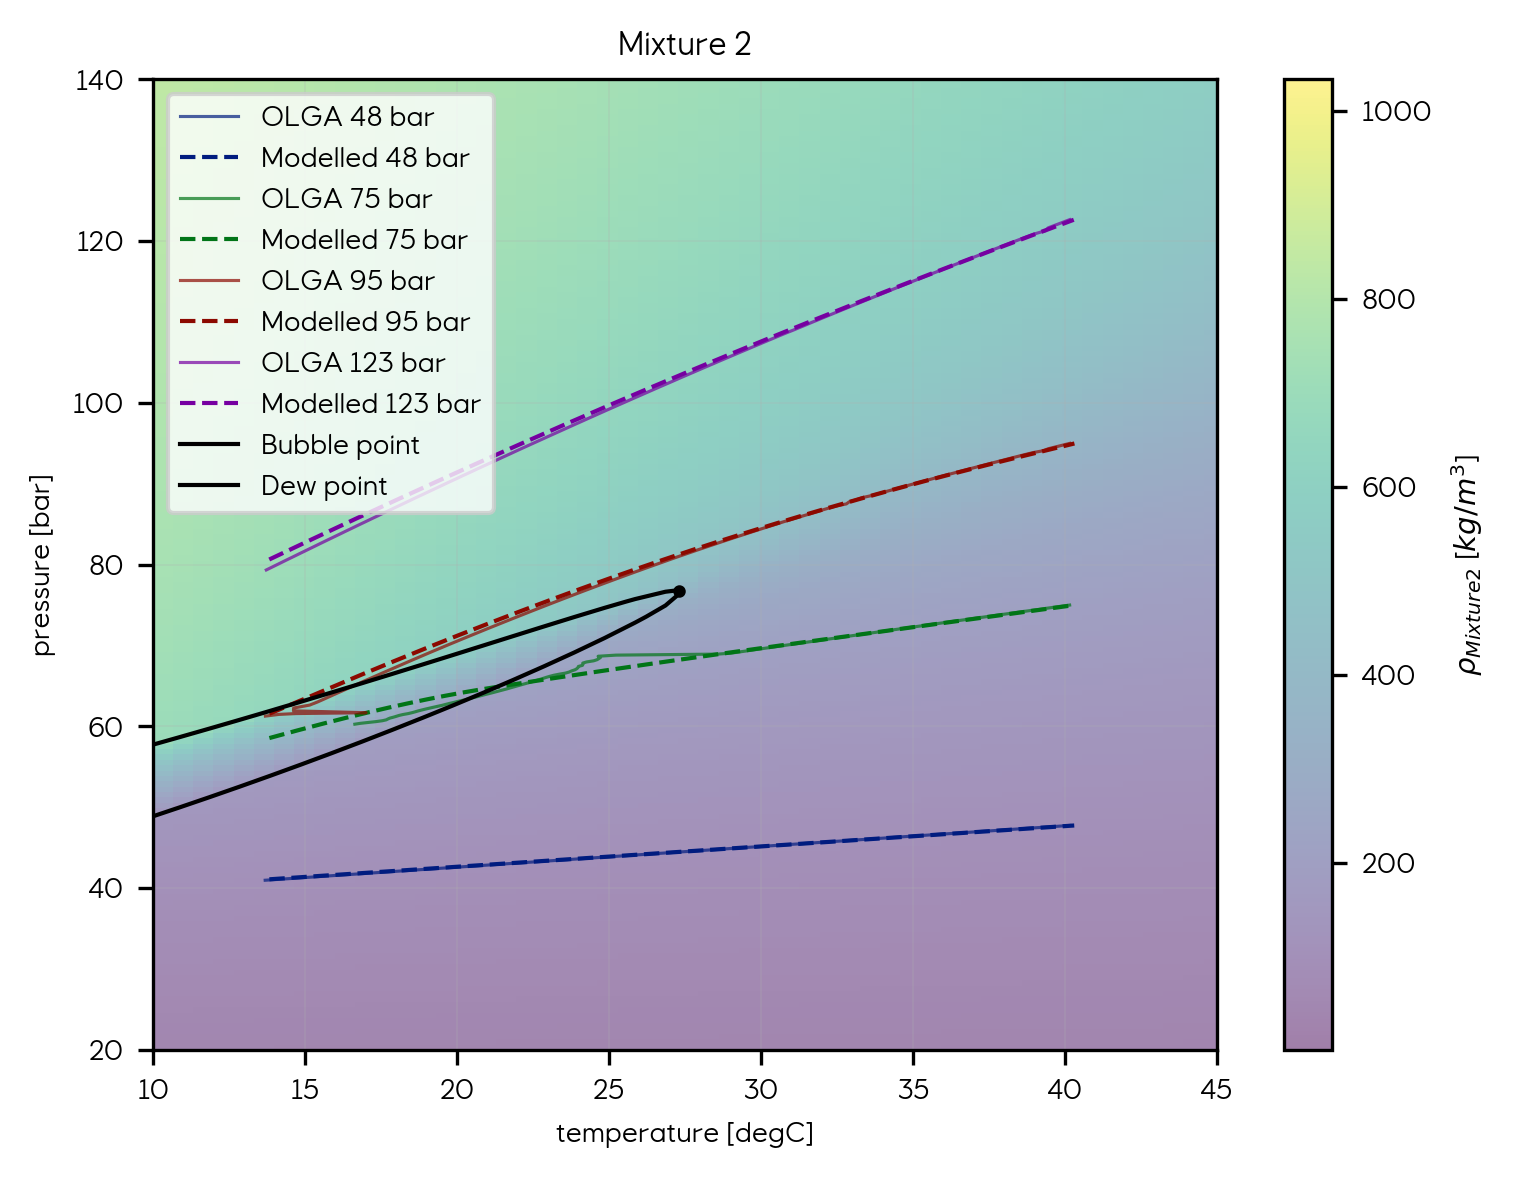

In [60]:
# Plot tables
from itertools import cycle

height = 10 / (const.inch * 100)
width = 13 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_mix2 = ax.pcolormesh(mix2_pvt_data["temperature"], mix2_pvt_data["pressure"], mix2_pvt_data["mixture2"]["rho"], alpha=0.5)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")


for idx, row in scenario_definition_df.query("fluid_id == 'mixture2'").iterrows():
    scenario = row["sc_name"]
    modelled_table = modelled_tables[scenario].query("depth>=250+312")
    olga_table = all_tables[scenario].query("depth>=250")

    olga_line = ax.plot(olga_table["temperature"], olga_table["pressure"], label=f"OLGA {row['pressure']:.0f} bar", lw=0.75, alpha=0.7)
    color = olga_line[0].get_color()
    ax.plot(modelled_table["temperature"], modelled_table["fluid_pressure"], label=f"Modelled {row['pressure']:.0f} bar", lw=1, color=color, ls="--")


ax.plot(mix2_envelopes["bubble_point"][:, 0], mix2_envelopes["bubble_point"][:, 1], color="black", lw=1, label="Bubble point")
ax.plot(mix2_envelopes["dew_point"][:, 0], mix2_envelopes["dew_point"][:, 1], color="black", lw=1, label="Dew point")
ax.scatter([mix2_mixture_info["T_crit"]], [mix2_mixture_info["p_crit"]], color="black")
# for scenario, color in zip(p_models, color_cycle):
#     p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
#         "temperature", "fluid_pressure", ax=ax, label=f"PVT {scenario} bar", lw=1
#     )

#     ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

# ax.plot(mix2_T, mix2_P)

ax.set_xlim(10, 45)

ax.set_ylim(20, 140)
ax.legend()

fig.colorbar(rho_pcm_mix2, label=r"$\rho_{Mixture 2}$ [$kg/m^3$]")
ax.set_title("Mixture 2")


fig.tight_layout()

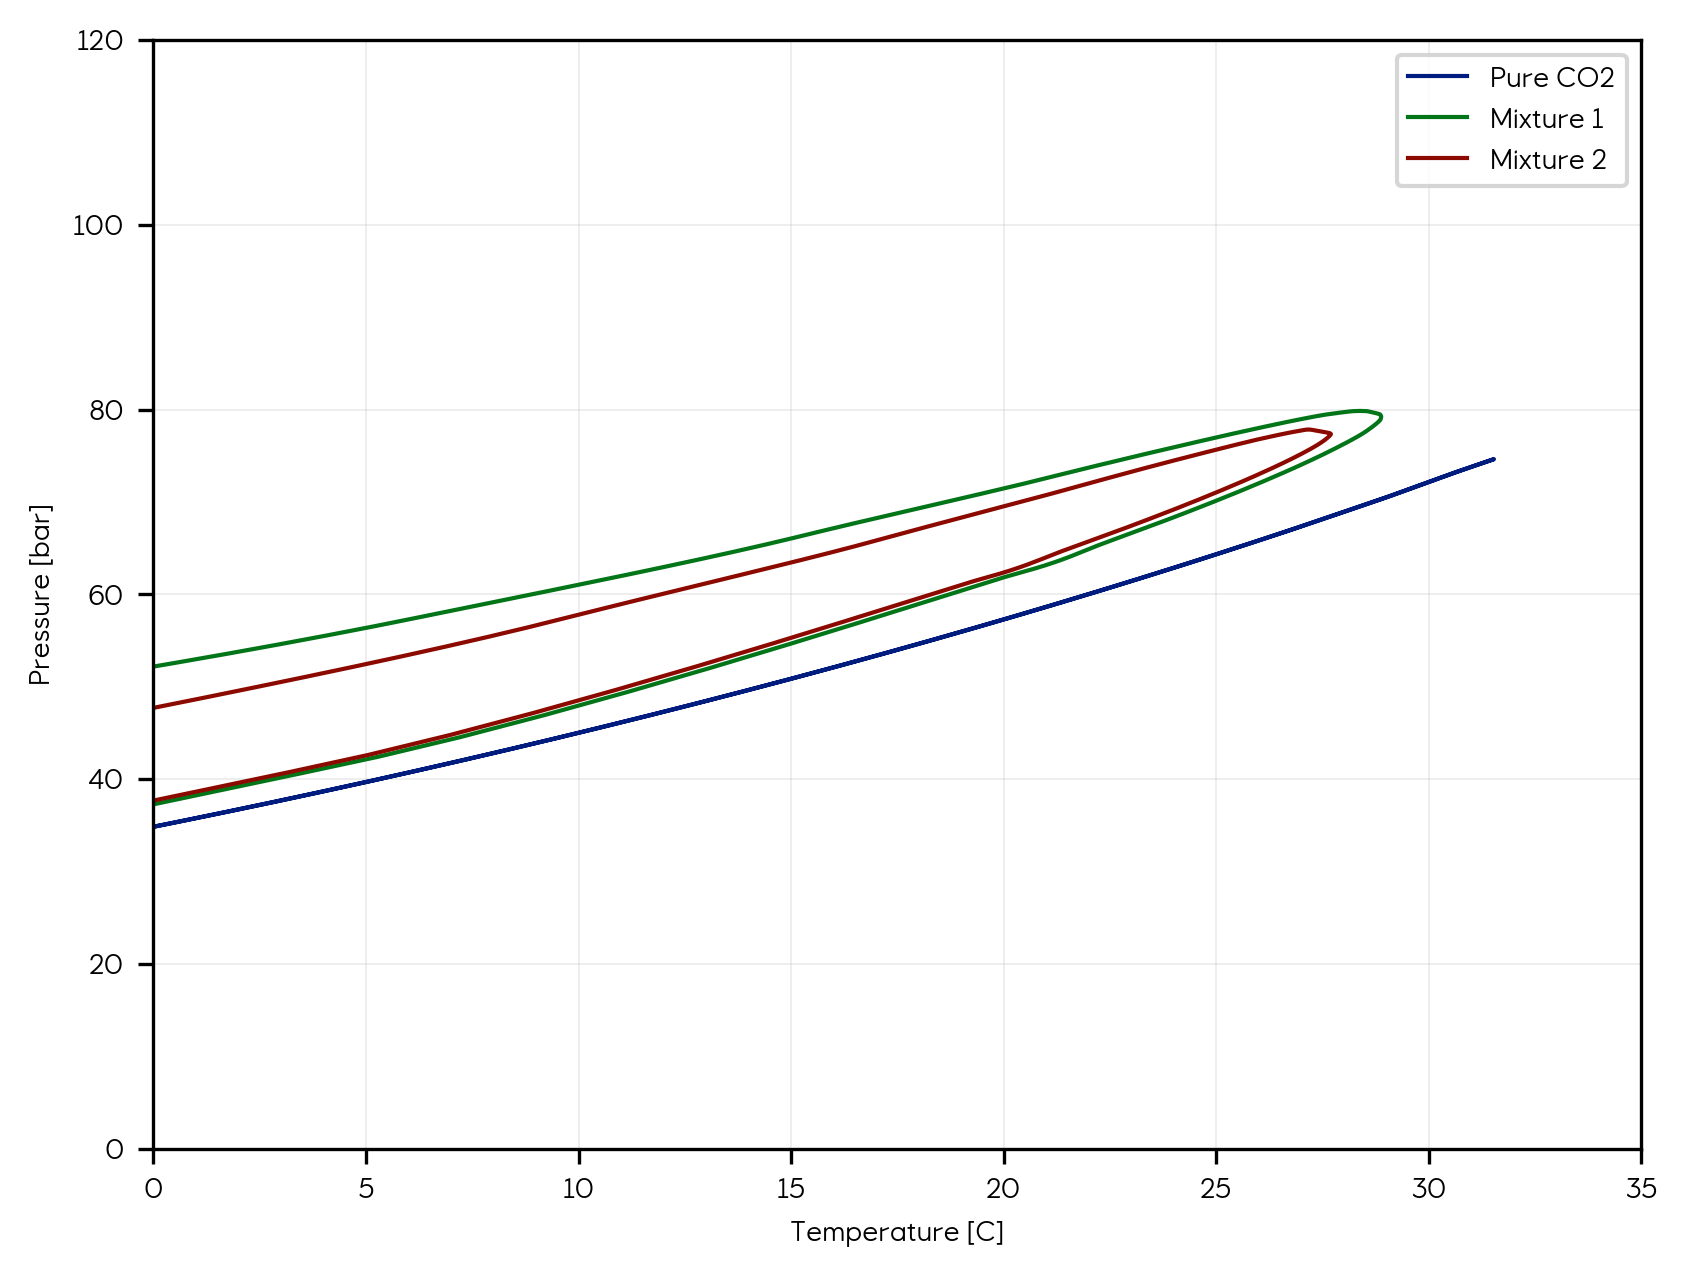

In [61]:
from scipy.interpolate import Akima1DInterpolator


def refine_envelope(envelope, k=3):
    x = np.array(envelope.T) - 273.15
    y = np.array(envelope.p) / 1e5

    param = np.linspace(0, 1, x.size)

    spl = Akima1DInterpolator(param, np.c_[x, y])
    x_smooth, y_smooth = spl(np.linspace(0, 1, x.size * 10)).T
    return x_smooth, y_smooth


# Pure CO2
pure_co2_component = ["CO2"]
pure_co2_mole_fraction = [1.0]

pure_co2_state = CP.AbstractState("HEOS", "&".join(pure_co2_component))
pure_co2_state.set_mole_fractions(pure_co2_mole_fraction)

pure_co2_state.build_phase_envelope("dummy")
pure_co2_PE = pure_co2_state.get_phase_envelope_data()

pure_co2_T, pure_co2_P = refine_envelope(pure_co2_PE)

# Mixture 1
mix1_components = ["CO2", "H2", "Argon", "Nitrogen", "Methane"]
mix1_mole_fractions = [0.96, 0.004, 0.01, 0.0082, 0.0178]

mix1_state = CP.AbstractState("HEOS", "&".join(mix1_components))
mix1_state.set_mole_fractions(mix1_mole_fractions)

mix1_state.build_phase_envelope("dummy")
mix1_PE = mix1_state.get_phase_envelope_data()

mix1_T, mix1_P = refine_envelope(mix1_PE)

# Mixture 2
mix2_components = ["CO2", "Methane"]
mix2_mole_fractions = [0.95, 0.05]

mix2_state = CP.AbstractState("HEOS", "&".join(mix2_components))
mix2_state.set_mole_fractions(mix2_mole_fractions)

mix2_state.build_phase_envelope("dummy")
mix2_PE = mix2_state.get_phase_envelope_data()

mix2_T, mix2_P = refine_envelope(mix2_PE)

fig, ax = plt.subplots()

ax.plot(pure_co2_T, pure_co2_P, "-", label="Pure CO2", lw=1)
# ax.scatter(np.array(pure_co2_PE.T)-273.15, np.array(pure_co2_PE.p)/1e5, label="Mixture 1")

ax.plot(mix1_T, mix1_P, "-", label="Mixture 1", lw=1)
# ax.scatter(np.array(mix1_PE.T)-273.15, np.array(mix1_PE.p)/1e5, label="Mixture 1")

ax.plot(mix2_T, mix2_P, "-", label="Mixture 2", lw=1)
# ax.scatter(np.array(mix2_PE.T)-273.15, np.array(mix2_PE.p)/1e5, label="Mixture 2")


ax.set_xlabel("Temperature [C]")
ax.set_ylabel("Pressure [bar]")

ax.set_xlim(0, 35)
ax.set_ylim(0, 120)
ax.legend()

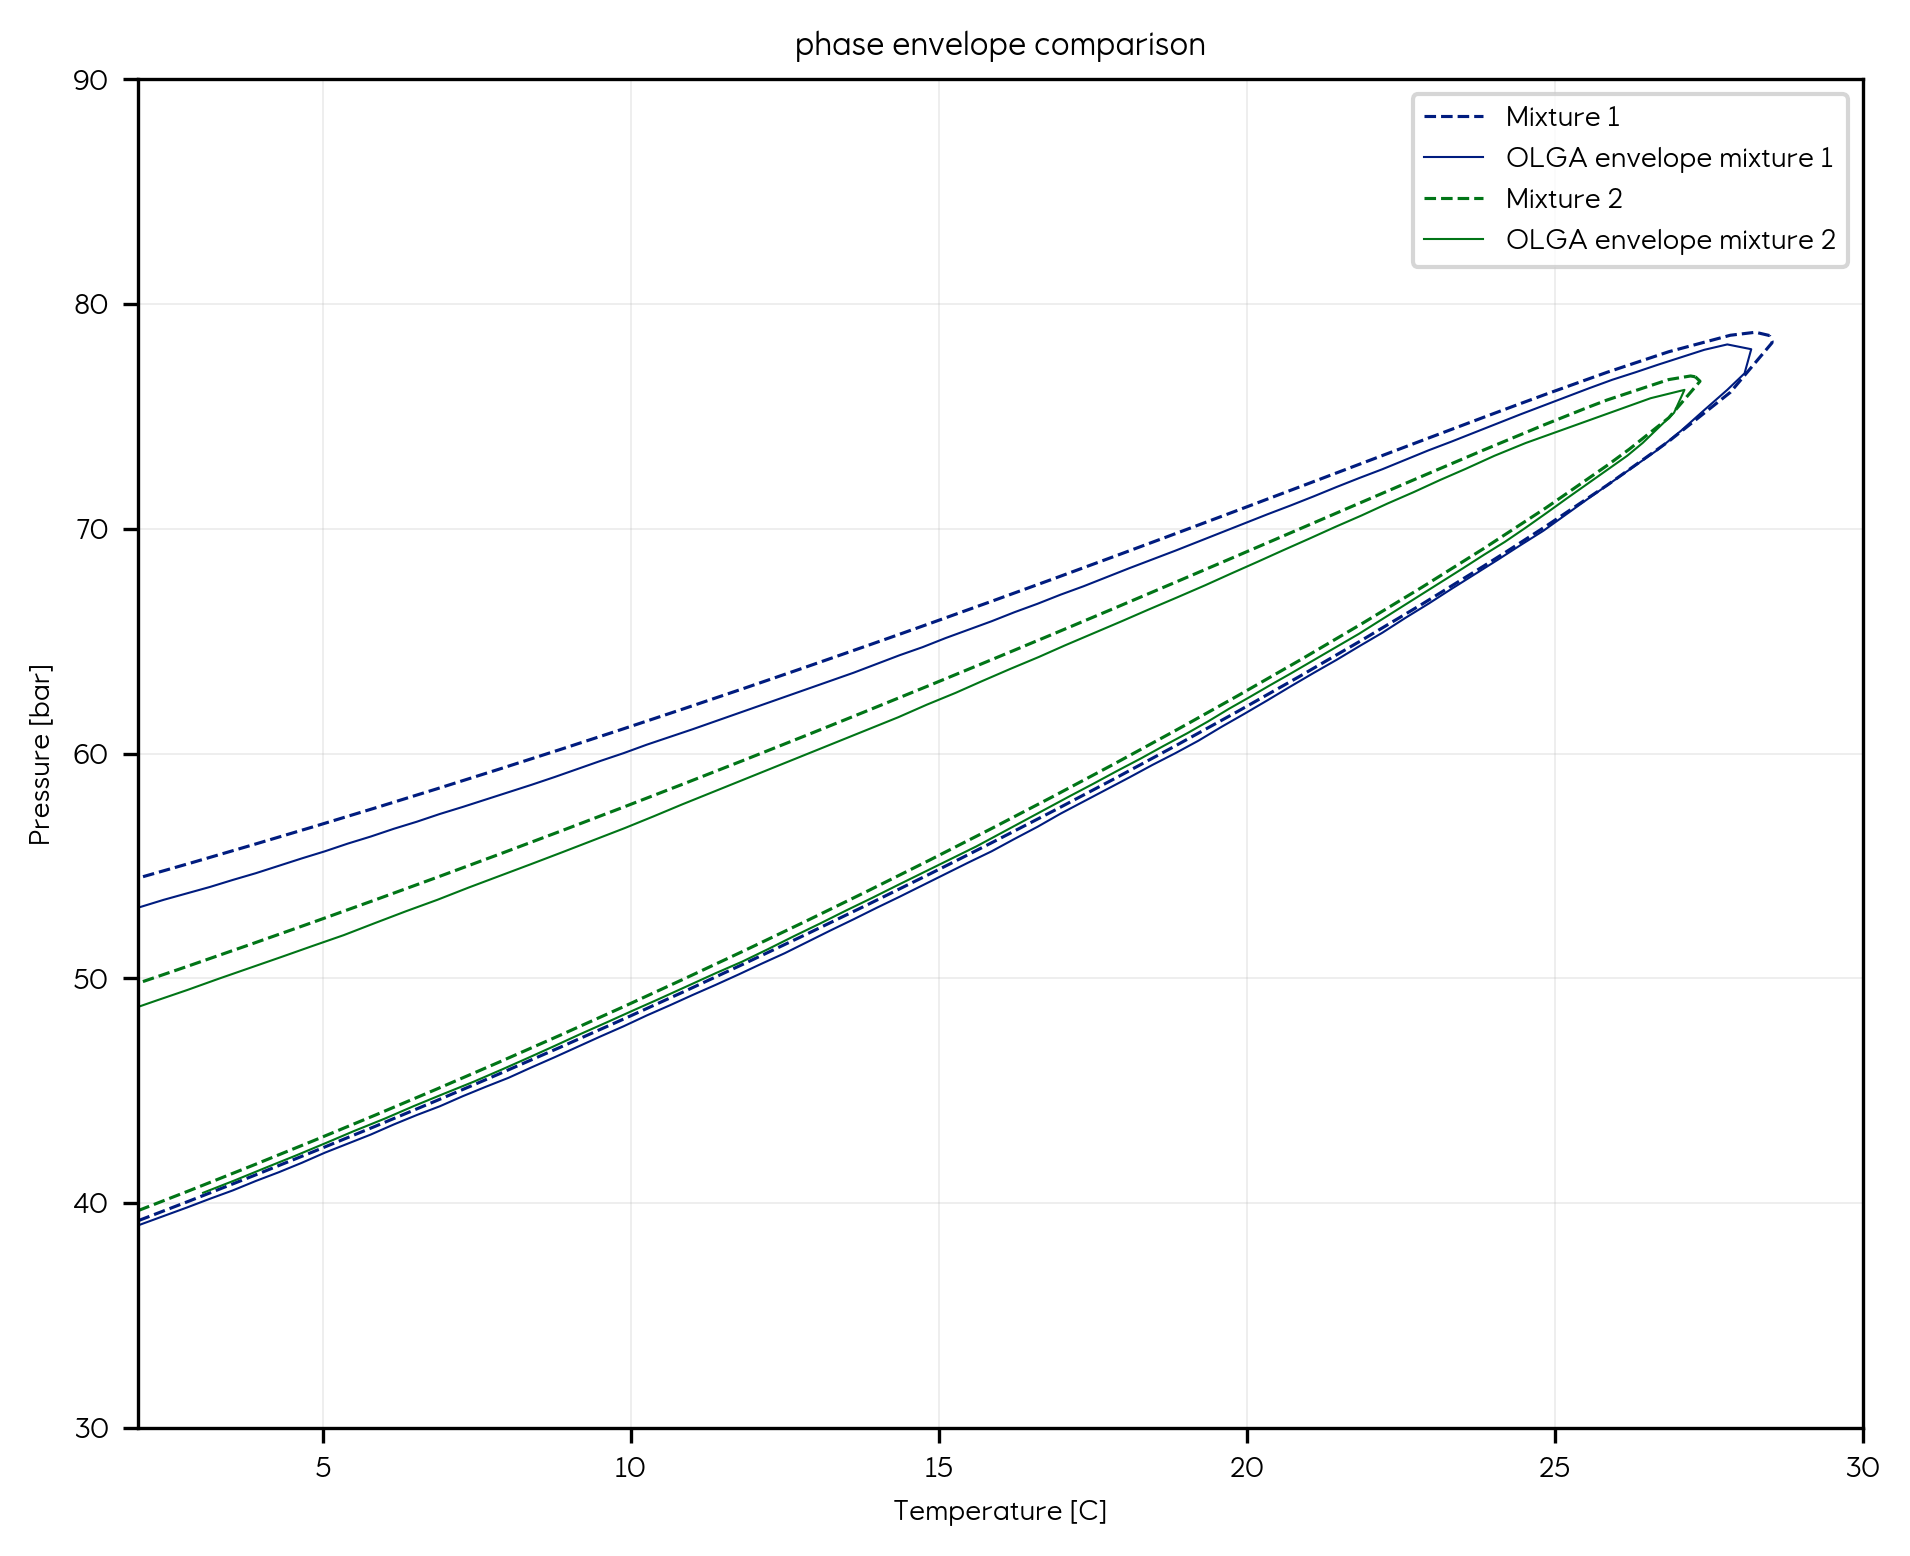

In [62]:
# data mix 1
t1 = [
    1.6691,
    2.0424,
    2.4157,
    2.7891,
    3.1624,
    3.5357,
    3.9090,
    4.2823,
    4.6556,
    5.0289,
    5.4022,
    5.7755,
    6.1488,
    6.5221,
    6.8954,
    7.2687,
    7.6420,
    8.0153,
    8.3886,
    8.7619,
    9.1352,
    9.5086,
    9.8819,
    10.2552,
    10.6285,
    11.0018,
    11.3751,
    11.7484,
    12.1217,
    12.4950,
    12.8683,
    13.2416,
    13.6149,
    13.9882,
    14.3615,
    14.7348,
    15.1081,
    15.4814,
    15.8548,
    16.2281,
    16.6014,
    16.9747,
    17.3480,
    17.7213,
    18.0946,
    18.4679,
    18.8412,
    19.2145,
    19.5878,
    19.9611,
    20.3344,
    20.7077,
    21.0810,
    21.4543,
    21.8276,
    22.2009,
    22.5743,
    22.9476,
    23.3209,
    23.6942,
    24.0675,
    24.4408,
    24.8141,
    25.1874,
    25.5607,
    25.9340,
    26.3073,
    26.6806,
    27.0539,
    27.4272,
    27.8005,
    28.1894,
    28.0805,
    27.8005,
    27.4272,
    27.0539,
    26.6806,
    26.3073,
    25.9340,
    25.5607,
    25.1874,
    24.8141,
    24.4408,
    24.0675,
    23.6942,
    23.3209,
    22.9476,
    22.5743,
    22.2009,
    21.8276,
    21.4543,
    21.0810,
    20.7077,
    20.3344,
    19.9611,
    19.5878,
    19.2145,
    18.8412,
    18.4679,
    18.0946,
    17.7213,
    17.3480,
    16.9747,
    16.6014,
    16.2281,
    15.8548,
    15.4814,
    15.1081,
    14.7348,
    14.3615,
    13.9882,
    13.6149,
    13.2416,
    12.8683,
    12.4950,
    12.1217,
    11.7484,
    11.3751,
    11.0018,
    10.6285,
    10.2552,
    9.8819,
    9.5086,
    9.1352,
    8.7619,
    8.3886,
    8.0153,
    7.6420,
    7.2687,
    6.8954,
    6.5221,
    6.1488,
    5.7755,
    5.4022,
    5.0289,
    4.6556,
    4.2823,
    3.9090,
    3.5357,
    3.1624,
    2.7891,
    2.4157,
    2.0424,
    1.6691,
]

p1 = [
    52.8988,
    53.1832,
    53.4975,
    53.7819,
    54.0663,
    54.3806,
    54.6800,
    55.0093,
    55.3386,
    55.6529,
    55.9971,
    56.3115,
    56.6557,
    56.9701,
    57.3143,
    57.6287,
    57.9579,
    58.2872,
    58.6165,
    58.9608,
    59.3200,
    59.6793,
    60.0235,
    60.3977,
    60.7420,
    61.0862,
    61.4455,
    61.8047,
    62.1639,
    62.5232,
    62.8824,
    63.2416,
    63.6009,
    63.9900,
    64.3792,
    64.7384,
    65.1426,
    65.5167,
    65.8909,
    66.2951,
    66.6693,
    67.0734,
    67.4476,
    67.8517,
    68.2559,
    68.6450,
    69.0342,
    69.4383,
    69.8425,
    70.2466,
    70.6507,
    71.0399,
    71.4440,
    71.8632,
    72.2673,
    72.6565,
    73.0756,
    73.4947,
    73.8838,
    74.2880,
    74.6921,
    75.0962,
    75.4854,
    75.8746,
    76.2637,
    76.6379,
    76.9672,
    77.3115,
    77.6408,
    77.9701,
    78.2096,
    77.9963,
    76.9223,
    76.1889,
    75.2908,
    74.3778,
    73.5396,
    72.8211,
    72.1026,
    71.3842,
    70.6507,
    69.9173,
    69.2737,
    68.6151,
    67.9715,
    67.3279,
    66.6693,
    66.0406,
    65.3820,
    64.7833,
    64.1696,
    63.5859,
    62.9872,
    62.3735,
    61.7748,
    61.1910,
    60.5773,
    60.0235,
    59.4996,
    58.9458,
    58.4070,
    57.8681,
    57.3293,
    56.7455,
    56.2067,
    55.6529,
    55.1589,
    54.6500,
    54.1411,
    53.6322,
    53.1383,
    52.6294,
    52.1354,
    51.6265,
    51.1176,
    50.6536,
    50.1746,
    49.7106,
    49.2616,
    48.7976,
    48.3485,
    47.8696,
    47.4205,
    46.9565,
    46.4925,
    46.0435,
    45.5795,
    45.1753,
    44.7562,
    44.3072,
    43.9180,
    43.4989,
    43.0499,
    42.6458,
    42.2416,
    41.7926,
    41.3735,
    40.9843,
    40.5652,
    40.1910,
    39.8019,
    39.4277,
    39.0535,
    38.6643,
]


t2 = [
    -7.3462,
    -6.8389,
    -6.3317,
    -5.8244,
    -5.3172,
    -4.8099,
    -4.3026,
    -3.7954,
    -3.2881,
    -2.7809,
    -2.2736,
    -1.7663,
    -1.2591,
    -0.7518,
    -0.2446,
    0.2627,
    0.7699,
    1.2772,
    1.7845,
    2.2917,
    2.7990,
    3.3062,
    3.8135,
    4.3208,
    4.8280,
    5.3353,
    5.8425,
    6.3498,
    6.8570,
    7.3643,
    7.8716,
    8.3788,
    8.8861,
    9.3933,
    9.9006,
    10.3656,
    10.8306,
    11.3378,
    11.8451,
    12.3523,
    12.8596,
    13.3669,
    13.8741,
    14.3391,
    14.8041,
    15.2691,
    15.6918,
    16.1568,
    16.6218,
    17.0445,
    17.5095,
    17.9745,
    18.3972,
    18.8622,
    19.3271,
    19.7499,
    20.1726,
    20.5953,
    21.0180,
    21.4407,
    21.8634,
    22.2861,
    22.7089,
    23.1316,
    23.5543,
    24.0193,
    24.5265,
    25.0338,
    25.5411,
    26.0483,
    26.5556,
    27.1051,
    26.9360,
    26.6824,
    26.4288,
    26.1751,
    25.8792,
    25.5411,
    25.2029,
    24.8647,
    24.5265,
    24.1884,
    23.8502,
    23.5120,
    23.1738,
    22.8357,
    22.4975,
    22.1593,
    21.8212,
    21.4830,
    21.1025,
    20.7221,
    20.3839,
    20.0458,
    19.7076,
    19.3694,
    19.0312,
    18.6508,
    18.2704,
    17.8899,
    17.5095,
    17.1290,
    16.7486,
    16.3681,
    15.9877,
    15.6072,
    15.1845,
    14.7618,
    14.3391,
    13.9164,
    13.4937,
    13.0710,
    12.6482,
    12.2255,
    11.8028,
    11.3801,
    10.9151,
    10.4501,
    10.0274,
    9.6047,
    9.1820,
    8.7593,
    8.3365,
    7.9138,
    7.4488,
    6.9416,
    6.4766,
    6.0116,
    5.5044,
    5.0394,
    4.5744,
    4.0671,
    3.5599,
    3.0526,
]

p2 = [
    40.5136,
    40.9419,
    41.3469,
    41.7674,
    42.1802,
    42.5929,
    43.0213,
    43.4730,
    43.9169,
    44.3686,
    44.8281,
    45.2720,
    45.7237,
    46.1676,
    46.6271,
    47.0788,
    47.5538,
    48.0367,
    48.5273,
    49.0102,
    49.4852,
    49.9837,
    50.4665,
    50.9494,
    51.4400,
    51.9228,
    52.4602,
    52.9898,
    53.4960,
    54.0411,
    54.5629,
    55.0847,
    55.6143,
    56.1517,
    56.6890,
    57.2077,
    57.7404,
    58.3011,
    58.8619,
    59.4226,
    59.9833,
    60.5440,
    61.1048,
    61.6188,
    62.1795,
    62.7028,
    63.2168,
    63.7682,
    64.3009,
    64.8149,
    65.3570,
    65.8990,
    66.4037,
    66.9457,
    67.4971,
    68.0204,
    68.5344,
    69.0578,
    69.5718,
    70.0951,
    70.5998,
    71.1325,
    71.6371,
    72.1698,
    72.6745,
    73.2539,
    73.8224,
    74.3208,
    74.8193,
    75.3177,
    75.8161,
    76.1873,
    75.1697,
    74.4999,
    73.8302,
    73.2539,
    72.6815,
    72.0273,
    71.3731,
    70.7072,
    70.0531,
    69.4222,
    68.8498,
    68.2541,
    67.6700,
    67.0859,
    66.5018,
    65.9177,
    65.3336,
    64.7962,
    64.1888,
    63.5813,
    63.0556,
    62.5183,
    61.9926,
    61.4319,
    60.9062,
    60.3478,
    59.7730,
    59.2263,
    58.6633,
    58.1142,
    57.5535,
    56.9928,
    56.4320,
    55.8713,
    55.3012,
    54.7312,
    54.1611,
    53.5817,
    53.0209,
    52.4415,
    51.8808,
    51.3014,
    50.7406,
    50.2360,
    49.6566,
    49.0771,
    48.5631,
    48.0398,
    47.5258,
    46.9931,
    46.4698,
    45.9558,
    45.4044,
    44.8436,
    44.3203,
    43.7689,
    43.2082,
    42.6661,
    42.1335,
    41.5727,
    41.0042,
    40.4591,
]


# Display the image
fig, ax1 = plt.subplots(figsize=(16.2 / 2.54, 13.2 / 2.54))

# img_mix1_extents = [1.453, 30, 24.737, 95.95]


# ax.scatter(np.array(mix1_PE.T)-273.15, np.array(mix1_PE.p)/1e5, label="Mixture 1")

mix1_line = ax1.plot(mix1_envelopes['bubble_point'][:,0], mix1_envelopes['bubble_point'][:,1], "--", label="Mixture 1", lw=0.75)

color1 = mix1_line[0].get_color()
mix1_line = ax1.plot(mix1_envelopes['dew_point'][:,0], mix1_envelopes['dew_point'][:,1], "--", lw=0.75, color=color1)

ax1.plot(t1, p1, color=color1, label="OLGA envelope mixture 1")

mix2_line = ax1.plot(mix2_envelopes['bubble_point'][:,0], mix2_envelopes['bubble_point'][:,1], "--", label="Mixture 2", lw=0.75)

color2 = mix2_line[0].get_color()
mix2_line = ax1.plot(mix2_envelopes['dew_point'][:,0], mix2_envelopes['dew_point'][:,1], "--", lw=0.75, color=color2)

ax1.plot(t2, p2, color=color2, label="OLGA envelope mixture 2")
# # Set axis limits to match the chart's axis values
ax1.set_xlim(2, 30)
ax1.set_ylim(30, 90)


ax1.set_xlabel("Temperature [C]")
ax1.set_ylabel("Pressure [bar]")

ax1.set_title(f"phase envelope comparison")


ax1.legend()


fig.tight_layout()
